In [1]:
import ThreeD_Net_Tools_0203 as D3

import sys
import math
import numpy as np #v 1.23.3
import networkx as nx
import matplotlib.cm as cm
import matplotlib
import argparse
import matplotlib.pyplot as plt
import itertools
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from networkx.algorithms import community
import community
from community import community_louvain #conda install python-louvain
from PIL import Image
import os
import scipy
from numpy import roots
import random
import ast
import pickle

#%matplotlib notebook

In [2]:
from networkx.utils import py_random_state


In [3]:
USR='LUKE'

In [4]:
#os.getcwd()
list_paths_skl=[]
list_paths_vol=[]
if USR=='LUKE':
    ALL_ANALYSIS='ALL_GAUDI.csv'#finalfilename
    #directory="/home/ll16598/Documents/ARCHITECTURAL_IMMUNITY/CURRENT_Gs/03-05-23_4"
    directory="/home/ll16598/Documents/ARCHITECTURAL_IMMUNITY/CURRENT_Gs/01-05-23_2"
    clean_Gs=directory+'/GRAPHS/CLEANED'
    dir_G=clean_Gs+"/BASE"
    dir_G_widths=clean_Gs+'/WIDTH'
    dir_G_widths_o=clean_Gs+'/WIDTH_O'
    #dir_G_coords=directory+"/COORDS"
    pickle_f=directory+"/_keyed_nodes.pickle"
    
    os.chdir(directory)
    
    #os.chdir("/media/ll16598/One Touch/CT_ANALYSIS/")
    #VOXEL_SIZES = pd.read_csv('/home/ll16598/Documents/ARCHITECTURAL_IMMUNITY/ANALYSIS/VOXEL_SIZES.csv')

elif USR=='SUPER':
    directory="/media/cf19810/One Touch/CT_ANALYSIS"
    dir_G="/media/cf19810/One Touch/CT_ANALYSIS/GRAPHS/BASE"
    dir_G_inverted='/media/cf19810/One Touch/CT_ANALYSIS/GRAPHS/INVERTED'
    dir_G_widths=clean_Gs+'/WIDTHS'
    dir_G_widths_inverted='/media/cf19810/One Touch/CT_ANALYSIS/GRAPHS/WIDTHS_INVERTED'
    dir_G_short="/media/cf19810/One Touch/CT_ANALYSIS/GRAPHS/SHORT"
    dir_G_spatial="/media/cf19810/One Touch/CT_ANALYSIS/GRAPHS/SPATIAL"
    dir_G_short_widths="/media/cf19810/One Touch/CT_ANALYSIS/GRAPHS/SHORT_WIDTH"
    dir_G_spatial_widths="/media/cf19810/One Touch/CT_ANALYSIS/GRAPHS/SPATIAL_WIDTH"
    
    os.chdir("/media/cf19810/One Touch/CT_ANALYSIS")
    VOXEL_SIZES = pd.read_csv('/home/cf19810/Documents/LUKE/VOXEL_SIZES.csv')

In [5]:
clean_Gs=directory+'/GRAPHS/CLEANED'

In [6]:
TREATS = pd.read_csv('/home/ll16598/Documents/ARCHITECTURAL_IMMUNITY/ANALYSIS/COLONY_INFO.csv')
analysis_df=TREATS

In [7]:
TREATS

,name,colony,order,week,day,time,voxel,subset,treatment
0,R1C1SK_TUE,1,1,1,TUE,0,0.016525,1,SHAM
1,R1C1SK_WED,1,1,1,WED,24,0.016555,1,SHAM
2,R1C1SK_THU,1,1,1,THU,48,0.016730,1,SHAM
3,R1C1SK_FRI,1,1,1,FRI,72,0.016539,1,SHAM
4,R1C1SK_MON,1,1,1,MON,144,0.016525,1,SHAM
...,...,...,...,...,...,...,...,...,...
95,R10C2SL_TUE,6,2,10,TUE,0,0.016583,20,SHAM
96,R10C2SL_WED,6,2,10,WED,24,0.016583,20,SHAM
97,R10C2SL_THU,6,2,10,THU,48,0.016577,20,SHAM
98,R10C2SL_FRI,6,2,10,FRI,72,0.016577,20,SHAM


In [8]:
name_list=[]
for i in TREATS['name']:
    name_list.append(i)

In [9]:
# dir_G='/home/ll16598/Documents/ARCHITECTURAL_IMMUNITY/GRAPHS/WIDTHS'
# dir_G_short='/home/ll16598/Documents/ARCHITECTURAL_IMMUNITY/GRAPHS/SHORT_WIDTH'
# dir_G_spatial='/home/ll16598/Documents/ARCHITECTURAL_IMMUNITY/GRAPHS/SPATIAL_WIDTH'

ENSURE YOU ARE RUNNING THE CORRECT GRAPHS. WIDTHS OR INVERTED.

In [10]:
WIDTH=True
WIDTH_O=False
SHORT=False
if SHORT==True:
    shorted='shortened_'
else:
    shorted=''

In [11]:
#if WIDTH_O==True:
files_width = [ f.path for f in os.scandir(dir_G_widths_o)]
files_length = [ f.path for f in os.scandir(dir_G)]

#print('WIDTH ONLY TAKEN INTO ACCOUNT')

if WIDTH==True:
    files = [ f.path for f in os.scandir(dir_G_widths)]
    files_inverted = [ f.path for f in os.scandir(dir_G_widths_inverted)]
    print('WIDTH TAKEN INTO ACCOUNT')
elif WIDTH==False:
    print('WIDTH NOT TAKEN INTO ACCOUNT')
    files = [ f.path for f in os.scandir(dir_G)]
    files_inverted = [ f.path for f in os.scandir(dir_G_inverted)]
#files_short = [ f.path for f in os.scandir(dir_G_short)]
#files_spatial = [ f.path for f in os.scandir(dir_G_spatial)]

NameError: name 'dir_G_widths_inverted' is not defined

If useing the reduced networks this will now average their edge weights.

In [12]:
files_width = [ f.path for f in os.scandir(dir_G_widths_o)]
files_length = [ f.path for f in os.scandir(dir_G)]

In [13]:
def invert_edge_weights (G_list):
    G_list_inverted=[]
    for g in range(len(G_list)):
        G1=G_list[g]
        G=G1.copy(G1)
        for u, v, data in G.edges(data=True):
            data['weight'] = 1/data['weight']
        G_list_inverted.append(G)
    return G_list_inverted

#this will invert the og graph, so is not useable

In [14]:
def remove_degree_two_nodes(G):
    """
    Remove all nodes with degree 2 and connects their neighbors with an edge
    whose weight is the sum of the previous edges.
    """
    G=G.copy()
    attributes = nx.get_node_attributes(G, 'TYPE')
    chamber_nodes = [node for node, type_value in attributes.items() if type_value == 'CHAM']
    nodes_to_remove = [node for node, degree in dict(G.degree()).items() if degree == 2 and node not in chamber_nodes]
    while len(nodes_to_remove)>0:
        for node in nodes_to_remove:
            # Neighbors of the node
            neighbors = list(G.neighbors(node))

            # Ensure there are exactly 2 neighbors
            if len(neighbors) != 2:
                continue

            # If the graph is weighted, sum the weights
            weight_sum = G[neighbors[0]][node]['weight'] + G[neighbors[1]][node]['weight']
            G.add_edge(neighbors[0], neighbors[1], weight=weight_sum)

            # Remove the node
            G.remove_node(node)
            nodes_to_remove = [node for node, degree in dict(G.degree()).items() if degree == 2 and node not in chamber_nodes]

    return G
def remove_degree_two_nodes_av(G):
    """
    Remove all nodes with degree 2 and connects their neighbors with an edge
    whose weight is the sum of the previous edges.
    """
    G=G.copy()
    attributes = nx.get_node_attributes(G, 'TYPE')
    chamber_nodes = [node for node, type_value in attributes.items() if type_value == 'CHAM']
    nodes_to_remove = [node for node, degree in dict(G.degree()).items() if degree == 2 and node not in chamber_nodes]
    while len(nodes_to_remove)>0:
        for node in nodes_to_remove:
            # Neighbors of the node
            neighbors = list(G.neighbors(node))

            # Ensure there are exactly 2 neighbors
            if len(neighbors) != 2:
                continue

            # If the graph is weighted, sum the weights
            weight_sum = (G[neighbors[0]][node]['weight'] + G[neighbors[1]][node]['weight'])/2
            G.add_edge(neighbors[0], neighbors[1], weight=weight_sum)


            # Remove the node
            G.remove_node(node)
            nodes_to_remove = [node for node, degree in dict(G.degree()).items() if degree == 2 and node not in chamber_nodes]

    return G
def divide_edge_weights(G1, G2):
    """
    Returns a graph where edge weights are obtained by dividing weights in G1 by weights in G2.
    Assumes G1 and G2 have the same structure.
    """
    G = G1.copy()
    for (u, v, data) in G1.edges(data=True):
        G[u][v]['weight'] = data['weight'] / G2[u][v]['weight']
    return G

In [15]:

#if WIDTH_O==True:   
all_names=[]
l=0
G_list_width_o=[]
while l<len(files_length) and len(G_list_width_o)<100:
    for file in range(0,len(files)):
        day=os.path.basename(files_width[file])
        filename = "_".join(day.split("_")[:2])  # Split by underscore, take first two parts, join with underscore
        if len(G_list_width_o)==100:
            break
        if filename == name_list[l]:
            G=nx.read_graphml(files_width[file])
            Gs = sorted(nx.connected_components(G), key=len, reverse=True)
            Gmax = G.subgraph(Gs[0])
            attributes = nx.get_node_attributes(Gmax, 'TYPE')
#     try:
            Gmax=remove_degree_two_nodes_av(Gmax)
            
            G_list_width_o.append(Gmax)
            print(filename)
            all_names.append(filename)
            l+=1
        else:
            l+=0
        if len(G_list_width_o)==100:
            break
            l+=1
        else:
            l+=0
            
G_list_length=[]
all_names=[]
l=0
while l<len(files) and len(G_list_length)<100:
    for file in range(0,len(files)):
        day=os.path.basename(files_length[file])
        filename = "_".join(day.split("_")[:2])  # Split by underscore, take first two parts, join with underscore
        if len(G_list_length)==100:
            break
        if filename == name_list[l]:
            G=nx.read_graphml(files_length[file])
            Gs = sorted(nx.connected_components(G), key=len, reverse=True)
            Gmax = G.subgraph(Gs[0])
            attributes = nx.get_node_attributes(Gmax, 'TYPE')
#     try:
            Gmax=remove_degree_two_nodes(Gmax)
            G_list_length.append(Gmax)
            print(filename)
            all_names.append(filename)
            l+=1
        else:
            l+=0
        if len(G_list_length)==100:
            break
           # print(filename, name_list[l])
#             break
   # analysis_df['chamber_count']=cham_count
G_list = [divide_edge_weights(G1, G2) for G1, G2 in zip(G_list_length, G_list_width_o)]
def print_edge_weights(G):
    for u, v, data in G.edges(data=True):
        weight = data.get('weight', 1)  # Default weight to 1 if no weight attribute
        print(f"Edge ({u}, {v}): Weight = {weight}")

for G in G_list:
    node_degrees = dict(G.degree())
    print_edge_weights(G)

    for node, degree in node_degrees.items():
        if degree==2:
            print(f"Node {node} has {degree} connections.")

R1C1SK_TUE
R1C1SK_WED
R1C1SK_THU
R1C1SK_FRI
R1C1SK_MON
R1C2PM_TUE
R1C2PM_WED
R1C2PM_THU
R1C2PM_FRI
R1C2PM_MON
R2C1PK_TUE
R2C1PK_WED
R2C1PK_THU
R2C1PK_FRI
R2C1PK_MON
R2C2SM_TUE
R2C2SM_WED
R2C2SM_THU
R2C2SM_FRI
R2C2SM_MON
R3C1SK_TUE
R3C1SK_WED
R3C1SK_THU
R3C1SK_FRI
R3C1SK_MON
R3C2PM_TUE
R3C2PM_WED
R3C2PM_THU
R3C2PM_FRI
R3C2PM_MON
R4C1PK_TUE
R4C1PK_WED
R4C1PK_THU
R4C1PK_FRI
R4C1PK_MON
R4C2SM_TUE
R4C2SM_WED
R4C2SM_THU
R4C2SM_FRI
R4C2SM_MON
R5C1SK_TUE
R5C1SK_WED
R5C1SK_THU
R5C1SK_FRI
R5C1SK_MON
R5C2PM_TUE
R5C2PM_WED
R5C2PM_THU
R5C2PM_FRI
R5C2PM_MON
R6C1PK_TUE
R6C1PK_WED
R6C1PK_THU
R6C1PK_FRI
R6C1PK_MON
R6C2SM_TUE
R6C2SM_WED
R6C2SM_THU
R6C2SM_FRI
R6C2SM_MON
R7C1SK_TUE
R7C1SK_WED
R7C1SK_THU
R7C1SK_FRI
R7C1SK_MON
R7C2PM_TUE
R7C2PM_WED
R7C2PM_THU
R7C2PM_FRI
R7C2PM_MON
R8C1PL_TUE
R8C1PL_WED
R8C1PL_THU
R8C1PL_FRI
R8C1PL_MON
R8C2SL_TUE
R8C2SL_WED
R8C2SL_THU
R8C2SL_FRI
R8C2SL_MON
R9C1SL_TUE
R9C1SL_WED
R9C1SL_THU
R9C1SL_FRI
R9C1SL_MON
R9C2PL_TUE
R9C2PL_WED
R9C2PL_THU
R9C2PL_FRI
R9C2PL_MON
R10C1PL_TU

This is the flow graph anlysis where entrances, chambers and endpoints can be treated as sources/sinks.

In [16]:
first_sections = [name.split('_')[0] for name in name_list]

In [17]:
for G in G_list:
    node_degrees = dict(G.degree())
    print_edge_weights(G)

Edge (2, 7): Weight = 5.183024611046227
Edge (2, 4): Weight = 9.499690370002803
Edge (2, 1): Weight = 2.7649857892942653
Edge (7, 8): Weight = 2.218846885444969
Edge (7, 12): Weight = 8.347402839720585
Edge (7, 9): Weight = 3.131095525392685
Edge (15, 14): Weight = 9.438230832692893
Edge (15, 5): Weight = 2.830542629091503
Edge (15, 10): Weight = 2.2995322267338776
Edge (3, 10): Weight = 2.780744645014755
Edge (10, 6): Weight = 1.946281716903377
Edge (6, 1): Weight = 18.449459710783394
Edge (6, 11): Weight = 2.1888420241531565
Edge (1, 13): Weight = 1.3459323493755961
Edge (38, 57): Weight = 20.06955454012785
Edge (38, 56): Weight = 22.52580202219564
Edge (38, 46): Weight = 19.782901532495302
Edge (57, 49): Weight = 31.928520188872753
Edge (57, 23): Weight = 4.231530872678516
Edge (27, 39): Weight = 11.824814101131402
Edge (27, 28): Weight = 5.773932133213789
Edge (27, 26): Weight = 4.590841271663032
Edge (39, 51): Weight = 20.288406892503843
Edge (39, 18): Weight = 16.49778332790909
E

In [18]:
for G in G_list_width_o:
    node_degrees = dict(G.degree())
    print_edge_weights(G)

Edge (2, 7): Weight = 0.49575300000000005
Edge (2, 4): Weight = 0.49575300000000005
Edge (2, 1): Weight = 0.49575300000000005
Edge (7, 8): Weight = 0.49575300000000005
Edge (7, 12): Weight = 0.49575300000000005
Edge (7, 9): Weight = 0.49575300000000005
Edge (15, 14): Weight = 0.49575300000000005
Edge (15, 5): Weight = 0.49575300000000005
Edge (15, 10): Weight = 0.49575300000000005
Edge (3, 10): Weight = 0.49575300000000005
Edge (10, 6): Weight = 0.49575300000000005
Edge (6, 1): Weight = 0.49575300000000005
Edge (6, 11): Weight = 0.49575300000000005
Edge (1, 13): Weight = 0.49575300000000005
Edge (38, 57): Weight = 0.45525424999999997
Edge (38, 56): Weight = 0.31453929999999997
Edge (38, 46): Weight = 0.0827735
Edge (57, 49): Weight = 0.33937134999999996
Edge (57, 23): Weight = 0.9601725999999999
Edge (27, 39): Weight = 0.331094
Edge (27, 28): Weight = 0.5794144999999999
Edge (27, 26): Weight = 0.24004314999999998
Edge (39, 51): Weight = 0.29798459999999993
Edge (39, 18): Weight = 0.339

In [19]:
for G in G_list_length:
    node_degrees = dict(G.degree())
    print_edge_weights(G)

Edge (2, 7): Weight = 2.5695
Edge (2, 4): Weight = 4.7095
Edge (2, 1): Weight = 1.3707500000000001
Edge (7, 8): Weight = 1.0999999999999999
Edge (7, 12): Weight = 4.13825
Edge (7, 9): Weight = 1.55225
Edge (15, 14): Weight = 4.67903125
Edge (15, 5): Weight = 1.4032499999999999
Edge (15, 10): Weight = 1.1400000000000001
Edge (3, 10): Weight = 1.3785625
Edge (10, 6): Weight = 0.9648749999999999
Edge (6, 1): Weight = 9.146375
Edge (6, 11): Weight = 1.085125
Edge (1, 13): Weight = 0.66725
Edge (38, 57): Weight = 9.13675
Edge (38, 56): Weight = 7.08525
Edge (38, 46): Weight = 1.6375
Edge (57, 49): Weight = 10.835625
Edge (57, 23): Weight = 4.063
Edge (27, 39): Weight = 3.915125
Edge (27, 28): Weight = 3.3455000000000004
Edge (27, 26): Weight = 1.1019999999999999
Edge (39, 51): Weight = 6.045632812499999
Edge (39, 18): Weight = 5.5988750000000005
Edge (30, 54): Weight = 5.4156875
Edge (54, 19): Weight = 2.0186875
Edge (54, 23): Weight = 3.9696875000000005
Edge (36, 26): Weight = 2.6470000000

In [68]:
def robustness(G):
    G=G.copy()
    attributes = nx.get_node_attributes(G, 'TYPE')
    chamber_nodes = [node for node, type_value in attributes.items() if type_value == 'CHAM']

    original_node_num=len(G.nodes())
    original_node_num=len(chamber_nodes)
    original_node_num=nx.global_efficiency(G)
    nodes_main_ccp=[]
    nodes_removed=0
    S=[]
    F=[]
    #while len(G.nodes())>0:
    while len(chamber_nodes)>0:
        #nodes=list(G.nodes())
        node_to_rm=random.choice(chamber_nodes)
        G.remove_node(node_to_rm)
        Gs = sorted(nx.connected_components(G), key=len, reverse=True)
        try:
            Gmax = G.subgraph(Gs[0])
        except IndexError:
            break
        attributes = nx.get_node_attributes(Gmax, 'TYPE')
        chamber_nodes = [node for node, type_value in attributes.items() if type_value == 'CHAM']
        if len(chamber_nodes)==0:
            break
        nodes_main_ccp=len(chamber_nodes)
        #nodes_main_ccp=len(Gmax.nodes())
        eff_main_ccp=nx.global_efficiency(Gmax)
        nodes_removed+=1
        #relative_size=nodes_main_ccp/original_node_num
        relative_size=eff_main_ccp/original_node_num

        fraction_rm=nodes_removed/nodes_main_ccp
        S.append(relative_size)
        F.append(fraction_rm)
        G=Gmax.copy()
        
    return S, F

In [69]:
F_list

[4.765682227811484,
 9.639225424512977,
 14.355105282378616,
 19.011844720168863,
 23.397982187000594,
 6.258540073985933,
 12.597211410227164,
 18.91738673695453,
 25.313820290973453,
 32.03849327080415,
 38.36595560346909,
 44.81955991550012,
 51.90231691896309,
 58.380385096988896,
 64.86614106324107,
 71.59898158884938,
 77.94721198401696,
 5.062451613890307,
 10.686590594601254,
 16.137415768453867,
 21.64521040323952,
 27.455891609085345,
 33.00795871144691,
 38.680369138245794,
 44.06931826026562,
 49.539850722324175,
 55.10325899914524,
 60.36865491201992,
 67.23400082699219,
 73.76963015959537,
 81.06004300320778,
 86.27202802437681,
 94.82519228799298,
 101.26256530068397,
 106.99044262664084,
 3.6587611427264815,
 7.373829979311405,
 11.207509927007072,
 15.009875209739365,
 18.590557051316537,
 22.9058726334624,
 4.3219049907136124,
 8.691896113281075,
 13.07703119562534,
 17.81039111216674,
 22.487382015835827,
 25.03891123727551,
 30.16464578169288,
 35.11107338927081,
 3

TypeError: 'Axes' object is not subscriptable

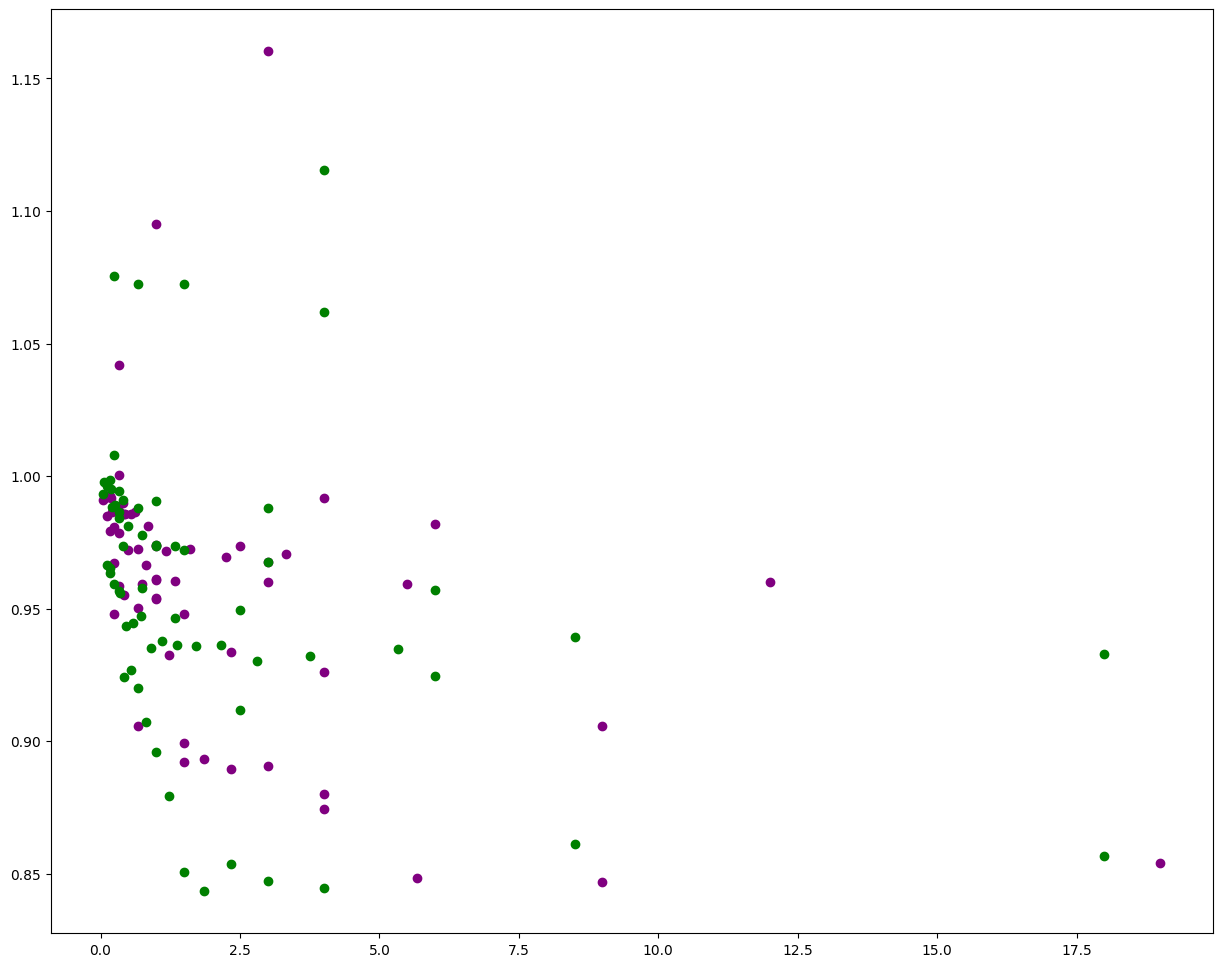

In [73]:
pntalpha=1
S_list=[]
F_list=[]
step=5
g=4
while g < len(G_list):
    G = G_list[g]
    S, F=robustness(G)
    S_list.extend(S)
    F_list.extend(F)
    # Alternate step size between 10 and 5
    if step == 10:
        step = 5
    else:
        step = 10
    g+=step
    
S_list2=[]
F_list2=[]
step=10
g=9
while g < len(G_list):
    G = G_list[g]
    S, F=robustness(G)
    S_list2.extend(S)
    F_list2.extend(F)
    # Alternate step size between 10 and 5
    if step == 10:
        step = 5
    else:
        step = 10
    g+=step

# 3. Plot histogram

fig, axes = plt.subplots(1, 1, figsize=(15, 12))
axes.scatter(F_list, S_list, color='purple', alpha=pntalpha)
axes.scatter(F_list2, S_list2, color='green', alpha=pntalpha)




axes[1, 1].set_title("Power-law fit (List 3 & 4)")

plt.tight_layout()
plt.show()

In [22]:
# for g in range(0,len(G_list)):
#     G_l=G_list_length[g]
#     G_wo=G_list_width_o[g]
#     G=G_list[g]
#     name=all_names[g]
#     nx.write_graphml(G, clean_Gs+'/WIDTH/'+name+ "_graph.xml")
#     nx.write_graphml(G_l, clean_Gs+'/BASE/'+name+ "_graph.xml")
#     nx.write_graphml(G_wo, clean_Gs+'/WIDTH_O/'+name+ "_graph.xml")


In [38]:
G_list_inverted=invert_edge_weights(G_list)

This is path length analysis. it runs between chambers and nest entrances (ch-ne), chambers and chambers (ch_ch) and nest-entrances to nest entrances (ne_ne). Looks confusing but short_path is the number of edges in the shortest path. This is repeated using Dijkstra's algorithm, which factors in weights, not edge number (short_paths_list_spatial). For network and dijkstra methods there is also the associated total path length - tot_paths for network; sptl_paths for Dijkstra.

In [39]:
def paths (G, list1, list2, traversal_list):
    chamber_nodes=list1
    nest_nodes=list2
    all_short_paths=[]
    all_short_paths_spatial=[]
    all_tot_paths=[]
    all_spatial_paths=[]
    shortest_short_paths=[]
    shortest_short_paths_spatial=[]
    shortest_tot_paths=[]
    shortest_spatial_paths=[]
    all_network_cham_traversed=[]
    all_spatial_cham_traversed=[]
    all_path_ids=[]
    if len(chamber_nodes)>0:
        for chamber in chamber_nodes:
            shortest_paths=[]
            total_paths=[]
            spatial_paths=[]
            shortest_paths_spatial=[]
            p_shortest_paths=[]
            p_total_paths=[]
            p_spatial_paths=[]
            p_shortest_paths_spatial=[]
        
            net_cham_traversed_list=[]
            sptl_cham_traversed_list=[]
            path_ids=[]
            for nest in nest_nodes:
                try:
                    path = nx.shortest_path(G, source=chamber, target=nest)
                    path_ids.append(tuple([chamber, nest]))
                    network_cham_traversed=[]
                    for node in path:
                        if node in traversal_list and node!=chamber:
                            network_cham_traversed.append(node)
                    network_cham_traversed=len(network_cham_traversed)
                    net_cham_traversed_list.append(network_cham_traversed)
                    
                    #path_spatial is the shortest euclidean path
                    path_spatial = nx.dijkstra_path(G, source=nest, target=chamber, weight='weight')
                    
                    sptl_cham_traversed=[]
                    for node in path_spatial:
                        if node in traversal_list and node!=chamber:
                            sptl_cham_traversed.append(node)
                    sptl_cham_traversed=len(sptl_cham_traversed)
                    sptl_cham_traversed_list.append(sptl_cham_traversed)
                    
                    edges_spatial = [(path_spatial[i], path_spatial[i+1]) for i in range(len(path_spatial)-1)]
                    edge_weights_spatial = [G.get_edge_data(path_spatial[i], path_spatial[i+1])['weight'] for i in range(len(path_spatial) - 1)]
                    edge_num_spatial=len(edges_spatial)
                    path_dist_spatial=np.sum(edge_weights_spatial)
                    shortest_paths_spatial.append(edge_num_spatial)
                    spatial_paths.append(path_dist_spatial)#print("Shortest path between {} and {}: {}".format(chamber, nest, path))
                    edges = [(path[i], path[i+1]) for i in range(len(path)-1)]
                    edge_weights = [G.get_edge_data(path[i], path[i+1])['weight'] for i in range(len(path) - 1)]
                    edge_num=len(edges)
                    path_dist=np.sum(edge_weights)
                    shortest_paths.append(edge_num)
                    total_paths.append(path_dist)
                    
                except nx.NetworkXNoPath:
                    print("No path found between {} and {}".format(chamber, nest))
            l=100
            for path in shortest_paths:
                if path<l:
                    l=path
            if l==100:
                l=np.nan
            p_shortest_paths.append(l)
            l=100
            for path in total_paths:
                if path<l:
                    l=path
            if l==100:
                l=np.nan
            p_total_paths.append(l)
            l=100
            for path in spatial_paths:
                if path<l:
                    l=path
            if l==100:
                l=np.nan
            p_spatial_paths.append(l)
            l=100
            for path in shortest_paths_spatial:
                if path<l:
                    l=path
            if l==100:
                l=np.nan
            p_shortest_paths_spatial.append(l)
            
            all_short_paths.extend(shortest_paths)
            all_tot_paths.extend(total_paths)
            all_spatial_paths.extend(spatial_paths)
            all_short_paths_spatial.extend(shortest_paths_spatial)
            shortest_short_paths.extend(p_shortest_paths)
            shortest_short_paths_spatial.extend(p_shortest_paths_spatial)
            shortest_tot_paths.extend(p_total_paths)
            shortest_spatial_paths.extend(p_shortest_paths_spatial)
        
            all_network_cham_traversed.extend(net_cham_traversed_list)
            all_spatial_cham_traversed.extend(sptl_cham_traversed_list)
            all_path_ids.extend(path_ids)

    else:
        all_short_paths=np.nan
        all_tot_paths=np.nan
        all_spatial_paths=np.nan
        all_short_paths_spatial=np.nan
        shortest_short_paths=np.nan
        shortest_short_paths_spatial=np.nan
        shortest_tot_paths=np.nan
        shortest_spatial_paths=np.nan
        
        all_network_cham_traversed=np.nan
        all_sptl_cham_traversed=np.nan
        all_path_ids=np.nan
    return all_short_paths, all_tot_paths, all_spatial_paths, all_short_paths_spatial, shortest_short_paths, shortest_short_paths_spatial, shortest_tot_paths, shortest_spatial_paths, all_network_cham_traversed, all_spatial_cham_traversed, all_path_ids

This calculates path lengths for an attribute between itself.

In [40]:
def calculate_edge_vertical_angle(p1, p2):
    # Define the vertical vector
    vertical_vector = np.array([0, 0, 1])

    # Calculate the edge vector
    edge_vector = np.array(p2) - np.array(p1)


    # Calculate the magnitudes of the vectors
    edge_magnitude = np.linalg.norm(edge_vector)
    vertical_magnitude = np.linalg.norm(vertical_vector)
    if edge_magnitude == 0:
        return 0

    # Calculate the dot product of the edge vector and the vertical vector
    dot_product = np.dot(edge_vector, vertical_vector)
    # Use the dot product formula to calculate the cosine of the angle
    cos_angle = dot_product / (edge_magnitude * vertical_magnitude)

    # Use the arccos function to get the angle in radians
    angle_rad = math.acos(cos_angle)
    angle=math.degrees(angle_rad)
    return angle


In [41]:
G_list_inverted=invert_edge_weights(G_list)

In [42]:

def calculate_orientation(pointA, pointB):
    x1, y1, z1 = pointA
    x2, y2, z2 = pointB

    # Ensure pointA is the one closest to the origin
    if math.dist([0,0], (x1, y1)) > math.dist([0,0], (x2, y2)):
        pointA, pointB = pointB, pointA  # Swap points

    x1, y1, z1 = pointA
    x2, y2, z2 = pointB

    delta_x = x2 - x1
    delta_y = y2 - y1
    delta_z = z2 - z1

    # Calculate the azimuth angle (bearing)
    angle_rad = math.atan2(delta_y, delta_x)
    angle_deg = math.degrees(angle_rad)
    bearing = -angle_deg + 90
    if bearing < 0:
        bearing += 360

    # Calculate the inclination angle
    horizontal_distance = math.sqrt(delta_x ** 2 + delta_y ** 2)
    inclination = math.degrees(math.atan2(delta_z, horizontal_distance))

    if inclination < 0:
        inclination += 180

    return bearing, inclination

In [43]:
for edge in G.edges:
    azimuth, inclin = calculate_orientation(ast.literal_eval(G.nodes[edge[1]]['coord']), 
                                          ast.literal_eval(G.nodes[edge[0]]['coord']))


In [44]:
import collections as collections
def calculate_entropy(G):
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())

    # calculate the probabilities
    prob = [i/sum(cnt) for i in cnt]

    # calculate the entropy
    entropy = -sum([p*math.log2(p) for p in prob])
    return entropy
import networkx as nx
import math

def calculate_weighted_entropy_no_ang(G):
    # Calculate the weighted degree of each node
    weighted_degrees = [sum(w['weight'] for w in G[n].values()) for n in G.nodes()]

    # Calculate the total weight in the network
    total_weight = sum(weighted_degrees)

    # Calculate the probability of each weighted degree
    prob = [wd / total_weight for wd in weighted_degrees]

    # Calculate the entropy
    entropy = -sum(p * math.log2(p) for p in prob if p > 0)  # Avoid log(0)
    return entropy

def calculate_laplacian_entropy(G):
    # Calculate the Laplacian of the graph
    L = nx.laplacian_matrix(G, weight='weight').toarray()

    # Calculate the eigenvalues of the Laplacian
    eigenvalues = np.linalg.eigvals(L)

    # Calculate the total of the eigenvalues
    total = np.sum(eigenvalues)

    # Normalize the eigenvalues to get a probability distribution
    prob = eigenvalues / total

    # Calculate the entropy of the eigenvalue distribution
    entropy = -np.sum(p * np.log2(p) for p in prob if p > 0)  # Avoid log(0)

    return entropy
# def calculate_weighted_entropy(G):
#     G2=G.copy()
#     G2.remove_edges_from(list(nx.selfloop_edges(G2)))
#     G=G2
#     # Calculate the angle and weight for each edge
#     angles_weights = [(calculate_edge_vertical_angle(ast.literal_eval(G.nodes[edge[0]]['coord']), ast.literal_eval(G.nodes[edge[1]]['coord'])), G.edges[edge]['weight']) for edge in G.edges()]

#     # Group by angle and sum weights
#     angle_weight_dict = collections.Counter()
#     for angle, weight in angles_weights:
#         # Convert angle to degrees and shift by -5 degrees
#        # shifted_angle = angle - 2.5
#         # Bin angle into one of the 36 bins, each representing 10 degrees
#         binned_angle = ((angle+5) // 10) * 10 #round(angle, 10)  # This rounds to the nearest multiple of 10
#         binned_angle=angle
#         #print(binned_angle)
#         #angle_weight_dict[binned_angle] += weight

#     # Calculate the total weight
#     total_weight = sum(angle_weight_dict.values())

#     # Calculate the probability of each binned angle
#     prob = [weight / total_weight for weight in angle_weight_dict.values()]

#     # Calculate the entropy
#     entropy = -sum(p * math.log(p) if p > 0 else 0 for p in prob)  # Avoid log(0)

#     return entropy, angles_weights
def calculate_unweighted_entropy(G):
    G2=G.copy()
    G2.remove_edges_from(list(nx.selfloop_edges(G2)))
    G=G2
    
    # Calculate the angle for each edge
    orient_dict = collections.Counter()
    orients=[]
    for edge in G.edges:
        azimuth, inclin = calculate_orientation(ast.literal_eval(G.nodes[edge[1]]['coord']), 
                                              ast.literal_eval(G.nodes[edge[0]]['coord']))
        orients.append(tuple([azimuth, inclin, edge]))
    # Count occurrences of each angle
    angles=[]
    for orient in orients:
        angle=orient[0]-5
        if angle<0:
            angle=360+angle
        inclin=orient[1]-5
        if inclin<0:
            inclin=180+angle
        binned_angle = ((angle) // 10) * 10 +5#round(angle, 10)  # This rounds to the nearest multiple of 10
        binned_inclin = ((inclin) // 10) * 10 +5
        angles.append(tuple([binned_angle,binned_inclin]))
    # Calculate the total number of edges
    angle_count_dict = collections.Counter(angles)

    # Calculate the total number of edges
    total_count = sum(angle_count_dict.values())
    print([count for count in angle_count_dict.values()])
    # Calculate the probability of each binned angle
    prob = [count / total_count for count in angle_count_dict.values()]
    # Calculate the entropy
    entropy = -sum(p * math.log(p) if p > 0 else 0 for p in prob)  # Avoid log(0)
    
    return entropy, angles

entropy_list_lap=[]
entropy_list=[]
cycles=[]
for g in range(0,len(G_list_inverted)):
    G_i=G_list_inverted[g]
    G=G_list[g]
    #entropy=calculate_entropy(G)
    entropy, li=calculate_unweighted_entropy(G)
    lap_entropy=calculate_laplacian_entropy(G)
    entropy_list_lap.append(lap_entropy)
    entropy_list.append(entropy)
#     DG = G.to_directed()
#     cycles.append(len(list(nx.simple_cycles(DG))))
#     print('G DONE: ', g)


analysis_df['entropy_lap']=entropy_list_lap
analysis_df['entropy']=entropy_list
#analysis_df['cycles']=cycles


analysis_df.to_csv(directory+"/"+shorted+'GRAPH_ANALYSIS_ENTROPY.csv',index=False)#S+PARAMETERS

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1]
[1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

/tmp/ipykernel_33807/1557649860.py:44: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  entropy = -np.sum(p * np.log2(p) for p in prob if p > 0)  # Avoid log(0)


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1

In [45]:

def get_vector(edge):
    """Returns vector of edge."""
    #edge=ast.literal_eval(edge)
    return [edge[1][i]-edge[0][i] for i in range(3)]

def get_angle_between_edges(edge1, edge2):
    """Returns angle between two edges."""
    vector1 = get_vector(edge1)
    vector2 = get_vector(edge2)
    dot_product = np.dot(vector1, vector2)
    norm1 = np.linalg.norm(vector1)
    norm2 = np.linalg.norm(vector2)
    cosine = dot_product / (norm1 * norm2)
    # Clipping the cosine value within the valid range for acos
    clipped_cosine = np.clip(cosine, -1, 1)
    return math.acos(clipped_cosine)

def heading_cost_estimate(current_edge, next_edge):
    """Estimates cost based on heading change."""
    return get_angle_between_edges(current_edge, next_edge)
def shortest_path_with_heading_change(network, source, target, weight='weight'):
    """Returns shortest path from source to target based on A* algorithm."""

    def astar_heuristic(u, v):
        """Heuristic for A* algorithm."""
        if v == target:
            return 0
        current_edge = (ast.literal_eval(network.nodes[u]['coord']), ast.literal_eval(network.nodes[v]['coord']))
        next_edge = (ast.literal_eval(network.nodes[v]['coord']), ast.literal_eval(network.nodes[target]['coord']))
        return heading_cost_estimate(current_edge, next_edge)

    path = nx.astar_path(network, source, target, heuristic=astar_heuristic, weight=weight)

    # Calculate total heading change and total weight
    total_heading_change = 0
    total_weight = 0
    for i in range(len(path)-1):
        current_edge = (ast.literal_eval(network.nodes[path[i]]['coord']), ast.literal_eval(network.nodes[path[i+1]]['coord']))
        next_edge = (ast.literal_eval(network.nodes[path[i+1]]['coord']), ast.literal_eval(network.nodes[path[(i+2)%len(path)]]['coord']))
        total_heading_change += heading_cost_estimate(current_edge, next_edge)
        total_weight += network.edges[path[i], path[i+1]][weight]

    return path, total_heading_change, total_weight

path_dist_list=[]
for G_cop in G_list:
    path_dist=[]
    attributes = nx.get_node_attributes(G_cop, 'TYPE')
    chamber_nodes = [node for node, type_value in attributes.items() if type_value == 'CHAM']
    nest_nodes = [node for node, type_value in attributes.items() if type_value == 'NEST EN']
    for ch in chamber_nodes:
        for ne in nest_nodes:
            path_head, total_heading_change, total_weight = shortest_path_with_heading_change(G_cop,ch, ne, weight='weight')
            path_dist.append(total_weight)
    path_dist_list.append(path_dist)
analysis_df['path_ang']=path_dist_list

In [46]:
total_heading_change

6.642346605200258

In [47]:
def calculate_meshedness(G):
    E = G.number_of_edges()
    N = G.number_of_nodes()
    
    if N > 2:  # To prevent division by zero and negative values
        M = (E - N + 1) / (2*N - 5)
        return M
    else:
        print("Error: The network must contain more than 2 nodes.")
        return None

In [48]:
list_mesh=[]
for G in G_list:
    mesh=calculate_meshedness(G)
    list_mesh.append(mesh)
    
analysis_df['list_mesh']=list_mesh

In [49]:
#now calculate CHAMBER TO CHAMBER PATHS
#traversal_list is the list of nodes you want to check have been traversed
def paths_same_attribute (G, list1, traversal_list):
    chamber_nodes=list1
    chamber_node2=list1
    chch_all_short_paths_list=[]
    chch_all_tot_paths_list=[]
    chch_all_sptl_paths_list=[]
    chch_all_short_paths_list_spatial=[]
    all_network_cham_traversed=[]
    all_spatial_cham_traversed=[]
    all_path_ids=[]
    if len(chamber_nodes)>0:
        chamber_nodes2=chamber_nodes
        completed_paths=[]
        for chamber in chamber_nodes:
            shortest_paths=[]
            total_paths=[]
            spatial_paths=[]
            shortest_paths_spatial=[]
            chch_all_short_paths_spatial=[]
            path_ids=[]
            net_cham_traversed_list=[]
            sptl_cham_traversed_list=[]
            
            for ch2 in chamber_nodes2:
                if chamber is not ch2 and tuple([chamber, ch2]) not in completed_paths and tuple([ch2, chamber]) not in completed_paths:
                    try:
                        completed_path = nx.shortest_path(G, source=ch2, target=chamber)
#                         if tuple([chamber, ch2]) in completed_paths:
#                             continue
#                         if tuple([ch2, chamber]) in completed_paths:
#                             continue
                        completed_paths.append(tuple([ch2, chamber]))
                        completed_paths.append(tuple([chamber, ch2]))
                        
                        path = nx.shortest_path(G, source=chamber, target=ch2)
                        path_ids.append(tuple([chamber, ch2]))
                        network_cham_traversed=[]
                        for node in path:
                            if node in traversal_list and node!=chamber:
                                network_cham_traversed.append(node)
                        network_cham_traversed=len(network_cham_traversed)
                        net_cham_traversed_list.append(network_cham_traversed)
                        
                        
                        #path_spatial is the shortest euclidean path
                        path_spatial = nx.dijkstra_path(G, source=chamber, target=ch2, weight='weight')
                        sptl_cham_traversed=[]
                        for node in path_spatial:
                            if node in traversal_list and node!=chamber:
                                sptl_cham_traversed.append(node)
                        sptl_cham_traversed=len(sptl_cham_traversed)
                        sptl_cham_traversed_list.append(sptl_cham_traversed)
                        
                        edges_spatial = [(path_spatial[i], path_spatial[i+1]) for i in range(len(path_spatial)-1)]
                        edge_weights_spatial = [G.get_edge_data(path_spatial[i], path_spatial[i+1])['weight'] for i in range(len(path_spatial) - 1)]
                        edge_num_spatial=len(edges_spatial)
                        path_dist_spatial=np.sum(edge_weights_spatial)
                        shortest_paths_spatial.append(edge_num_spatial)
                        spatial_paths.append(path_dist_spatial)#print("Shortest path between {} and {}: {}".format(chamber, nest, path))
                        edges = [(path[i], path[i+1]) for i in range(len(path)-1)]
                        edge_weights = [G.get_edge_data(path[i], path[i+1])['weight'] for i in range(len(path) - 1)]
                        edge_num=len(edges)
                        path_dist=np.sum(edge_weights)
                        shortest_paths.append(edge_num)
                        total_paths.append(path_dist)

                    except nx.NetworkXNoPath:
                        print("No path found between {} and {}".format(chamber, ch2))
            chch_all_short_paths_list.extend(shortest_paths)
            chch_all_tot_paths_list.extend(total_paths)
            chch_all_sptl_paths_list.extend(spatial_paths)
            chch_all_short_paths_list_spatial.extend(shortest_paths_spatial)
            
            all_network_cham_traversed.extend(net_cham_traversed_list)
            all_spatial_cham_traversed.extend(sptl_cham_traversed_list)
            all_path_ids.extend(path_ids)
    else:
        chch_all_short_paths=np.nan
        chch_all_tot_paths=np.nan
        chch_all_sptl_paths=np.nan
        chch_all_short_paths_spatial=np.nan
        
        all_network_cham_traversed=np.nan
        all_sptl_cham_traversed=np.nan
        all_path_ids=np.nan
    return chch_all_short_paths_list, chch_all_tot_paths_list, chch_all_sptl_paths_list, chch_all_short_paths_list_spatial, all_network_cham_traversed, all_spatial_cham_traversed, all_path_ids

In [50]:
#junction-junction paths
if SHORT==False:
    all_short_paths_list=[]
    all_tot_paths_list=[]
    all_sptl_paths_list=[]
    all_short_paths_list_spatial=[]

    #ch-ch paths
    chch_all_short_paths_list=[]
    chch_all_tot_paths_list=[]
    chch_all_sptl_paths_list=[]
    chch_all_short_paths_list_spatial=[]

    #j-ch paths
    jch_all_short_paths_list=[]
    jch_all_tot_paths_list=[]
    jch_all_sptl_paths_list=[]
    jch_all_short_paths_list_spatial=[]

    #ne-ch paths
    nech_all_short_paths_list=[]
    nech_all_tot_paths_list=[]
    nech_all_sptl_paths_list=[]
    nech_all_short_paths_list_spatial=[]
    
    nech_shortest_short_paths_list=[] 
    nech_shortest_short_paths_spatial_list=[]
    nech_shortest_tot_paths_list=[]
    nech_shortest_spatial_paths_list=[]

    NECH_COMBINED_PATH_LIST=[]
    CH_COMBINED_PATH_LIST=[]
    
    chch_all_network_cham_traversed_list=[] 
    chch_all_spatial_cham_traversed_list=[]
    
    nech_all_network_cham_traversed_list=[] 
    nech_all_spatial_cham_traversed_list=[]
    
    all_network_cham_traversed_list=[] 
    all_spatial_cham_traversed_list=[]
    
    ch_path_id_list=[]
    nech_path_id_list=[]
    all_path_id_list=[]
    for g in range(len(G_list)):    
        if WIDTH_O==True:
            G=G_list_inverted[g]
        else:
            G=G_list[g]
        
        attributes = nx.get_node_attributes(G, 'TYPE')
        #     try:
        nest_nodes = [node for node, type_value in attributes.items() if type_value == 'NEST EN']
        chamber_nodes = [node for node, type_value in attributes.items() if type_value == 'CHAM']
        junction_nodes = [node for node, type_value in attributes.items() if type_value == 'JUNC']
        end_nodes = [node for node, type_value in attributes.items() if type_value == 'END']
        
        all_nodes=list(nest_nodes+chamber_nodes+junction_nodes+end_nodes)
        all_short_paths, all_tot_paths, all_sptl_paths, all_short_paths_spatial, all_network_cham_traversed, \
        all_spatial_cham_traversed, all_path_ids=paths_same_attribute(G, all_nodes, all_nodes)

        #j_all_short_paths, j_all_tot_paths, j_all_sptl_paths, j_all_short_paths_spatial=paths_same_attribute(G, junction_nodes)
        ch_all_short_paths, ch_all_tot_paths, ch_all_sptl_paths, ch_all_short_paths_spatial, ch_all_network_cham_traversed, ch_all_spatial_cham_traversed, ch_path_ids=paths_same_attribute(G, chamber_nodes, chamber_nodes)
        #jch_all_short_paths, jch_all_tot_paths, jch_all_sptl_paths, jch_all_short_paths_spatial, jch_shortest_short_paths, jch_shortest_short_paths_spatial, jch_shortest_tot_paths, jch_shortest_spatial_paths=paths(G, chamber_nodes, junction_nodes)
        nech_all_short_paths, nech_all_tot_paths, nech_all_sptl_paths, \
        nech_all_short_paths_spatial, nech_shortest_short_paths, \
        nech_shortest_short_paths_spatial, nech_shortest_tot_paths, nech_shortest_spatial_paths,\
        nech_all_network_cham_traversed, nech_all_spatial_cham_traversed, nech_path_ids=paths(G, nest_nodes, chamber_nodes, chamber_nodes)
        #nej_all_short_paths_list, nej_all_tot_paths_list, nej_all_sptl_paths_list, nej_all_short_paths_list_spatial=paths(G, nest_nodes, junction_nodes)
        if len(chamber_nodes)>1:
            all_network_cham_traversed_list.append(all_network_cham_traversed)
            all_spatial_cham_traversed_list.append(all_spatial_cham_traversed)
            chch_all_network_cham_traversed_list.append(ch_all_network_cham_traversed)
            chch_all_spatial_cham_traversed_list.append(ch_all_spatial_cham_traversed)
            nech_all_network_cham_traversed_list.append(nech_all_network_cham_traversed)
            nech_all_spatial_cham_traversed_list.append(nech_all_spatial_cham_traversed)
        else:
            all_network_cham_traversed_list.append(np.nan)
            all_spatial_cham_traversed_list.append(np.nan)
            chch_all_network_cham_traversed_list.append(np.nan)
            chch_all_spatial_cham_traversed_list.append(np.nan)
            nech_all_network_cham_traversed_list.append(np.nan)
            nech_all_spatial_cham_traversed_list.append(np.nan)
            
        nech_combined=[]
        for i in range(len(nech_all_tot_paths)):
        # Calculate the mean of the corresponding elements at each index
            mean_val = (nech_all_tot_paths[i] + nech_all_sptl_paths[i]) / 2
            nech_combined.append(mean_val)
            # Append the mean value to the list
        NECH_COMBINED_PATH_LIST.append(nech_combined)

        ch_combined=[]
        for i in range(len(ch_all_tot_paths)):
        # Calculate the mean of the corresponding elements at each index
            mean_val = (ch_all_tot_paths[i] + ch_all_sptl_paths[i]) / 2
            ch_combined.append(mean_val)
            # Append the mean value to the list
        CH_COMBINED_PATH_LIST.append(ch_combined)



#         j_all_short_paths_list.append(j_all_short_paths)
#         j_all_tot_paths_list.append(j_all_tot_paths)
#         j_all_sptl_paths_list.append(j_all_sptl_paths)
#         j_all_short_paths_list_spatial.append(j_all_short_paths_spatial)

        #ch-ch paths
        chch_all_short_paths_list.append(ch_all_short_paths)
        chch_all_tot_paths_list.append(ch_all_tot_paths)
        chch_all_sptl_paths_list.append(ch_all_sptl_paths)
        chch_all_short_paths_list_spatial.append(ch_all_short_paths_spatial)

        all_short_paths_list.append(all_short_paths)
        all_tot_paths_list.append(all_tot_paths)
        all_sptl_paths_list.append(all_sptl_paths)
        all_short_paths_list_spatial.append(all_short_paths_spatial)

        #ne-ch paths
        nech_all_short_paths_list.append(nech_all_short_paths)
        nech_all_tot_paths_list.append(nech_all_tot_paths)
        nech_all_sptl_paths_list.append(nech_all_sptl_paths)
        nech_all_short_paths_list_spatial.append(nech_all_short_paths_spatial)
        
        nech_shortest_short_paths_list.append(nech_shortest_short_paths)
        nech_shortest_short_paths_spatial_list.append(nech_shortest_short_paths_spatial)
        nech_shortest_tot_paths_list.append(nech_shortest_tot_paths)
        nech_shortest_spatial_paths_list.append(nech_shortest_spatial_paths)
        
        nom = first_sections[g]
        chch_ids=[]
        try:
            for path in ch_path_ids:
                chch_ids.append(nom+'_'+str(path))
        except TypeError:
            chch_ids=np.nan
        nech_ids=[]
        try:
            for ncpath in nech_path_ids:
                nech_ids.append(nom+'_'+str(ncpath))
        except TypeError:
            nech_ids=np.nan
        all_ids=[]
        try:
            for path in all_path_ids:
                all_ids.append(nom+'_'+str(path))
        except TypeError:
            all_ids=np.nan            
        ch_path_id_list.append(chch_ids)
        nech_path_id_list.append(nech_ids)
        all_path_id_list.append(all_ids)

#     analysis_df['j_all_short_paths_list']=j_all_short_paths_list
#     analysis_df['j_all_tot_paths_list']=j_all_tot_paths_list
#     analysis_df['j_all_sptl_paths_list']=j_all_sptl_paths_list
#     analysis_df['j_all_short_paths_list_spatial']=j_all_short_paths_list_spatial

    analysis_df['chch_all_short_paths_list']=chch_all_short_paths_list
    analysis_df['chch_all_tot_paths_list']=chch_all_tot_paths_list
    analysis_df['chch_all_sptl_paths_list']=chch_all_sptl_paths_list
    analysis_df['chch_all_short_paths_list_spatial']=chch_all_short_paths_list_spatial

#     analysis_df['jch_all_short_paths_list']=jch_all_short_paths_list
#     analysis_df['jch_all_tot_paths_list']=jch_all_tot_paths_list
#     analysis_df['jch_all_sptl_paths_list']=jch_all_sptl_paths_list
#     analysis_df['jch_all_short_paths_list_spatial']=jch_all_short_paths_list_spatial

    analysis_df['nech_all_short_paths_list']=nech_all_short_paths_list
    analysis_df['nech_all_tot_paths_list']=nech_all_tot_paths_list
    analysis_df['nech_all_sptl_paths_list']=nech_all_sptl_paths_list
    analysis_df['nech_all_short_paths_list_spatial']=nech_all_short_paths_list_spatial

    analysis_df['all_short_paths_list']=all_short_paths_list
    analysis_df['all_tot_paths_list']=all_tot_paths_list
    analysis_df['all_sptl_paths_list']=all_sptl_paths_list
    analysis_df['all_short_paths_list_spatial']=all_short_paths_list_spatial

    analysis_df['nech_combined_paths_list']=NECH_COMBINED_PATH_LIST
    analysis_df['ch_combined_paths_list']=CH_COMBINED_PATH_LIST
    
    
    analysis_df['nech_shortest_short_paths_list']=nech_shortest_short_paths_list
    analysis_df['nech_shortest_short_paths_spatial_list']=nech_shortest_short_paths_spatial_list
    analysis_df['nech_shortest_tot_paths_list']=nech_shortest_tot_paths_list
    analysis_df['nech_shortest_spatial_paths_list']=nech_shortest_spatial_paths_list
    
    analysis_df['all_network_cham_traversed']=all_network_cham_traversed_list
    analysis_df['all_spatial_cham_traversed']=all_spatial_cham_traversed_list

    
    analysis_df['chch_all_network_cham_traversed']=chch_all_network_cham_traversed_list
    analysis_df['chch_all_spatial_cham_traversed']=chch_all_spatial_cham_traversed_list
    
    analysis_df['nech_all_network_cham_traversed']=nech_all_network_cham_traversed_list
    analysis_df['nech_all_spatial_cham_traversed']=nech_all_spatial_cham_traversed_list
    
    analysis_df['all_path_ids']=all_path_id_list
    analysis_df['ch_path_ids']=ch_path_id_list
    analysis_df['nech_path_ids']=nech_path_id_list

In [51]:
ne_thrsh=0.5 # this is the threshold for how close an NE must be to a prior to be considered new

In [52]:
#now for getting new paths mechanism.
new_route_lens=[]
OLD_NE_OLD_CH_COMBINED_PATH_LIST=[]
OLD_NE_NEW_CH_COMBINED_PATH_LIST=[]
NEW_NE_OLD_CH_COMBINED_PATH_LIST=[]
NEW_NE_NEW_CH_COMBINED_PATH_LIST=[]
NEW_NE_TO_NEW_NE_DIST=[]
ALL_NE_TO_NEW_CH_EUC_DIST=[]
OLD_CH_OLD_CH_COMBINED_PATH_LIST=[]
OLD_CH_NEW_CH_COMBINED_PATH_LIST=[]
NEW_CH_NEW_CH_COMBINED_PATH_LIST=[]
NEW_NE_TO_ANY_NE_DIST=[]

for g in range(len(G_list)):
    G=G_list[g]
    G_sub=G_list[g-1]
    old_nes=[]
    attributes = nx.get_node_attributes(G, 'TYPE')
    chamber_nodes = [node for node, type_value in attributes.items() if type_value == 'CHAM']
    nest_nodes = [node for node, type_value in attributes.items() if type_value == 'NEST EN']
    if g == 0 or g % 5 == 0:
        OLD_NE_NEW_CH_COMBINED_PATH_LIST.append(np.nan)
        NEW_NE_OLD_CH_COMBINED_PATH_LIST.append(np.nan)
        NEW_NE_NEW_CH_COMBINED_PATH_LIST.append(np.nan)
        ALL_NE_TO_NEW_CH_EUC_DIST.append(np.nan)
        OLD_CH_OLD_CH_COMBINED_PATH_LIST.append(np.nan)
        OLD_CH_NEW_CH_COMBINED_PATH_LIST.append(np.nan)
        NEW_CH_NEW_CH_COMBINED_PATH_LIST.append(np.nan)
        NEW_NE_TO_ANY_NE_DIST.append(np.nan)
        new_nes=nest_nodes
        new_nes2=new_nes
        ne_ne_dist=[]
        for ne in new_nes:
            for ne2 in new_nes2:
                if ne!=ne2:
                    ne_dist = D3.calculate_distance(ast.literal_eval(G.nodes[ne]['coord']),\
                                                    ast.literal_eval(G.nodes[ne2]['coord']))
                    ne_ne_dist.append(ne_dist)
        NEW_NE_TO_NEW_NE_DIST.append(ne_ne_dist)
        continue
    
    print(nest_nodes)
    attributes_sub = nx.get_node_attributes(G_sub, 'TYPE')
    chamber_nodes_sub = [node for node, type_value in attributes_sub.items() if type_value == 'CHAM']
    nest_nodes_sub = [node for node, type_value in attributes_sub.items() if type_value == 'NEST EN']
    
    new_cham=list(set(chamber_nodes)-set(chamber_nodes_sub))
    old_cham=list(set(chamber_nodes).intersection(chamber_nodes_sub))
    #we measure distances for nest entrances, since I do not trust identity maintenance for this class
#     for ne in nest_nodes:
#         for ne_sub in nest_nodes_sub:
#             dist = D3.calculate_distance(ast.literal_eval(G.nodes[ne]['coord']),ast.literal_eval(G_sub.nodes[ne_sub]['coord']))
#             if dist<ne_thrsh:
#                 old_nes.append(ne)
    new_nes=list(set(nest_nodes)-set(nest_nodes_sub))
    old_nes=list(set(nest_nodes).intersection(nest_nodes_sub))
    new_nes2=new_nes
    ne_ne_dist=[]
    for ne in new_nes:
        for ne2 in new_nes2:
            if ne!=ne2:
                ne_dist = D3.calculate_distance(ast.literal_eval(G.nodes[ne]['coord']),\
                                                ast.literal_eval(G.nodes[ne2]['coord']))
                ne_ne_dist.append(ne_dist)
    NEW_NE_TO_NEW_NE_DIST.append(ne_ne_dist)
    
    ne_ne_dist=[]
    for ne in new_nes:
        for ne2 in nest_nodes:
            if ne!=ne2:
                ne_dist = D3.calculate_distance(ast.literal_eval(G.nodes[ne]['coord']),\
                                                ast.literal_eval(G.nodes[ne2]['coord']))
                ne_ne_dist.append(ne_dist)
    NEW_NE_TO_ANY_NE_DIST.append(ne_ne_dist)
    
    ne_ch_euc_dist=[]
    for ne in nest_nodes:
        for ch in new_cham:
            nech_dist = D3.calculate_distance(ast.literal_eval(G.nodes[ne]['coord']),\
                                            ast.literal_eval(G.nodes[ch]['coord']))
            ne_ch_euc_dist.append(nech_dist)
    ALL_NE_TO_NEW_CH_EUC_DIST.append(ne_ch_euc_dist)
    

    
    #from all nes to new chambers
    nech_all_short_paths, nech_all_tot_paths, nech_all_sptl_paths, \
    nech_all_short_paths_spatial, shortest_short_paths, shortest_short_paths_spatial, \
    shortest_tot_paths, shortest_spatial_paths, all_network_cham_traversed, \
    all_spatial_cham_traversed, nech_path_ids\
    =paths(G, old_nes, new_cham, chamber_nodes)
    
    
    nech_all_short_paths1, nech_all_tot_paths1, nech_all_sptl_paths1, \
    nech_all_short_paths_spatial1, shortest_short_paths1, shortest_short_paths_spatial1, \
    shortest_tot_paths1, shortest_spatial_paths1, all_network_cham_traversed1, \
    all_spatial_cham_traversed1, nech_path_ids1\
    =paths(G, new_nes, old_cham, chamber_nodes)
    
    nech_all_short_paths2, nech_all_tot_paths2, nech_all_sptl_paths2, \
    nech_all_short_paths_spatial2, shortest_short_paths2, shortest_short_paths_spatial2, \
    shortest_tot_paths2, shortest_spatial_paths2, all_network_cham_traversed2, \
    all_spatial_cham_traversed2, nech_path_ids2\
    =paths(G, new_nes, new_cham, chamber_nodes)
    
    
    nech_all_short_paths3, nech_all_tot_paths3, nech_all_sptl_paths3, \
    nech_all_short_paths_spatial2, shortest_short_pathNEW_NE_TO_OLD_NE_DISTs2, shortest_short_paths_spatial3, \
    shortest_tot_paths3, shortest_spatial_paths3, all_network_cham_traversed3, \
    all_spatial_cham_traversed3, nech_path_ids3\
    =paths(G, old_nes, old_cham, chamber_nodes)
    
    OLD_NE_NEW_CH_COMBINED_PATH_LIST.append(nech_all_sptl_paths)
    NEW_NE_OLD_CH_COMBINED_PATH_LIST.append(nech_all_sptl_paths1)
    NEW_NE_NEW_CH_COMBINED_PATH_LIST.append(nech_all_sptl_paths2)
    OLD_NE_OLD_CH_COMBINED_PATH_LIST.append(nech_all_sptl_paths3)

    
    ch_all_short_paths, ch_all_tot_paths, ch_all_sptl_paths, \
    ch_all_short_paths_spatial, ch_all_network_cham_traversed, \
    ch_all_spatial_cham_traversed, \
    ch_path_ids=paths_same_attribute(G, old_cham, chamber_nodes)
    
    ch_all_short_paths1, ch_all_tot_paths1, ch_all_sptl_paths1, \
    ch_all_short_paths_spatial1, shortest_short_paths1, shortest_short_paths_spatial1, \
    shortest_tot_paths3, shortest_spatial_paths3, all_network_cham_traversed3, \
    all_spatial_cham_traversed1, ch_path_ids1=paths(G, old_cham, new_cham, chamber_nodes)
    
    ch_all_short_paths, ch_all_tot_paths, ch_all_sptl_paths2, \
    ch_all_short_paths_spatial, ch_all_network_cham_traversed, \
    ch_all_spatial_cham_traversed, \
    ch_path_ids=paths_same_attribute(G, old_cham, chamber_nodes)
    
    OLD_CH_OLD_CH_COMBINED_PATH_LIST.append(ch_all_sptl_paths)
    OLD_CH_NEW_CH_COMBINED_PATH_LIST.append(ch_all_sptl_paths1)
    NEW_CH_NEW_CH_COMBINED_PATH_LIST.append(ch_all_sptl_paths2)

analysis_df['OLD_NE_NEW_CH_COMBINED_PATH_LIST']=OLD_NE_NEW_CH_COMBINED_PATH_LIST
analysis_df['NEW_NE_OLD_CH_COMBINED_PATH_LIST']=NEW_NE_OLD_CH_COMBINED_PATH_LIST
analysis_df['NEW_NE_NEW_CH_COMBINED_PATH_LIST']=NEW_NE_NEW_CH_COMBINED_PATH_LIST
analysis_df['OLD_NE_OLD_CH_COMBINED_PATH_LIST']=NEW_NE_NEW_CH_COMBINED_PATH_LIST
analysis_df['OLD_CH_OLD_CH_COMBINED_PATH_LIST']=OLD_CH_OLD_CH_COMBINED_PATH_LIST
analysis_df['OLD_CH_NEW_CH_COMBINED_PATH_LIST']=OLD_CH_NEW_CH_COMBINED_PATH_LIST
analysis_df['NEW_CH_NEW_CH_COMBINED_PATH_LIST']=NEW_CH_NEW_CH_COMBINED_PATH_LIST
analysis_df['NEW_NE_TO_NEW_NE_DIST']=NEW_NE_TO_NEW_NE_DIST
analysis_df['ALL_NE_TO_NEW_CH_EUC_DIST']=ALL_NE_TO_NEW_CH_EUC_DIST
analysis_df['NEW_NE_TO_ANY_NE_DIST']=NEW_NE_TO_ANY_NE_DIST



['21', '55', '48', '44', '16', '20', '41', '37']
['55', '21', '41', '37', '44', '48']
['78', '2', '41', '75', '83', '66', '71']
['109', '44', '92', '90', '119', '103', '7']
['51', '61', '107', '86', '46', '97', '62', '63', '44']
['143', '61', '159', '107', '127', '132']
['260', '107', '159', '241', '286', '235', '186', '238', '143', '288', '213', '279', '233', '249']
['221', '107', '213', '346', '258', '344', '324', '159', '288', '342', '336', '327']
['39', '44', '62', '56', '52', '60', '49', '65', '55']
['39', '56', '55', '125', '108', '100', '62']
['148', '115', '100', '62', '108', '128', '56', '39', '144', '125']
['115', '180', '144', '39', '155', '108', '128', '175', '62', '56', '125']
['156', '138', '79', '103', '132', '164', '21']
['164', '299', '138', '103', '218', '217', '233', '202', '207', '129', '156']
['218', '216', '351', '271', '370', '261', '202', '233', '328', '217', '129', '207']
['370', '402', '202', '420', '351', '387', '407', '461', '244', '328', '399', '470', '466'

In [53]:
# small_world=[]
# for G in G_list:
#     small_world.append(nx.sigma(G))
# analysis_df['small_world']=small_world

In [54]:
#analysis_df.to_csv(directory+"/GRAPH_ANALYSIS_SIGMA.csv",index=False)#S+PARAMETERS


This calculates the shortest paths between all pairs of nodes in a g.. It does everything twice, using edge number and dijkstra distances. It returns the diamete in edges first, then the associated path, then for dijkstra it gives edge number between each pair then summed edge wights, then for network measure it does the  same.  This has been validated with the networkx out-of-the box measure.

In [55]:
DEG_STAND=False

In [56]:
if SHORT==False:
    max_spatial_edges_list=[]
    max_edge_diameter_list=[] 
    max_spatial_diameter_list=[]
    max_edge_spatial_path_list=[]
    spatial_edges_list=[]
    spatial_lengths_list=[]
    edge_paths_list=[]
    edge_length_list=[]
    for G in G_list:
        max_spatial_edges,max_edge_diameter, max_spatial_diameter,max_edge_spatial_path, spatial_edges, spatial_lengths, edge_paths, edge_lengths=D3.calculate_diameter(G)
        print('edge diam spatial/path=', max_spatial_edges, max_edge_diameter)
        print('spatial diam spatial/path=',max_spatial_diameter,max_edge_spatial_path)

        max_spatial_edges_list.append(max_spatial_edges)
        max_edge_diameter_list.append(max_edge_diameter)
        max_spatial_diameter_list.append(max_spatial_diameter)
        max_edge_spatial_path_list.append(max_edge_spatial_path)
        spatial_edges_list.append(spatial_edges)
        spatial_lengths_list.append(spatial_lengths)
        edge_paths_list.append(edge_paths)
        edge_length_list.append(edge_lengths)

    analysis_df['max_spatial_edges_list']=max_spatial_edges_list
    analysis_df['max_edge_diameter_list']=max_edge_diameter_list
    analysis_df['max_spatial_diameter_list']=max_spatial_diameter_list
    analysis_df['max_edge_spatial_path_list']=max_edge_spatial_path_list
    analysis_df['spatial_edges_list']=spatial_edges_list
    analysis_df['spatial_lengths_list']=spatial_lengths_list
    analysis_df['edge_paths_list']=edge_paths_list
    analysis_df['edge_length_list']=edge_length_list

edge diam spatial/path= 7 7
spatial diam spatial/path= 48.42891772717462 42.300361772899
edge diam spatial/path= 12 10
spatial diam spatial/path= 121.52313499973481 163.445796517105
edge diam spatial/path= 10 10
spatial diam spatial/path= 98.70757467343121 63.66980472159159
edge diam spatial/path= 7 8
spatial diam spatial/path= 164.69579292070694 133.70978961081445
edge diam spatial/path= 15 10
spatial diam spatial/path= 211.30744638424153 85.45903800755981
edge diam spatial/path= 8 10
spatial diam spatial/path= 232.9377622050497 73.07748218634403
edge diam spatial/path= 17 14
spatial diam spatial/path= 237.96261535858696 254.63462433009266
edge diam spatial/path= 13 13
spatial diam spatial/path= 84.29805427295494 93.28611336725382
edge diam spatial/path= 15 16
spatial diam spatial/path= 140.66548080634718 156.72506781718138
edge diam spatial/path= 16 16
spatial diam spatial/path= 106.46789161209905 157.11834768420746
edge diam spatial/path= 11 11
spatial diam spatial/path= 96.12034670

edge diam spatial/path= 8 9
spatial diam spatial/path= 103.43091296554883 74.79823909826591
edge diam spatial/path= 8 7
spatial diam spatial/path= 76.11391098730587 74.52616229698914
edge diam spatial/path= 12 10
spatial diam spatial/path= 83.01906824406775 70.04712614779169
edge diam spatial/path= 11 10
spatial diam spatial/path= 72.9878477031668 50.577644679869096
edge diam spatial/path= 11 10
spatial diam spatial/path= 130.14039068335103 79.00331787137706
edge diam spatial/path= 12 9
spatial diam spatial/path= 112.05532511738363 69.08442016525103


Main graph analysis:

In [58]:
STANDARDISE=True
if STANDARDISE==True:
    STD='_STD_'
else:
    STD=''
    
DEG_STAND=False

In [59]:

#uninverted measures


spatial_diameter_list=[]
max_edge_diameter_list=[]
max_edge_path_list =[]
connected_components_list=[]


deg_cen_list = []
mean_deg_cen_list = []
std_deg_cen_list = []
clust_coeff_list = []
mean_clust_list = []
std_clust_list = []
trans_list = []

square_clustering_list=[]
mean_square_clustering_list = []
std_square_clustering_list = []
triangles_list = []
density_list = []
standard_closeness_centrality_spatial_list=[]

closeness_centrality_spatial_list=[]
mean_closeness_centrality_spatial_list = []
std_closeness_centrality_spatial_list = []

degree_list=[]
mean_degree_list = []
std_degree_list = []

degree_centrality_list = []
mean_degree_centrality_list = []
std_degree_centrality_list = []

cham_degree_list = []
mean_chamber_degree_list = []
std_chamber_degree_list = []


cham_degree_centrality_list = []
mean_cham_deg_centrality_list = []
std_cham_deg_centrality_list = []

cham_closeness_spatial_list = []
mean_chamber_closeness_centrality_spatial_list = []
std_chamber_closeness_centrality_spatial_list = []

cham_clustering_list=[]
mean_cham_clustering_list=[]
std_cham_clustering_list=[]

junc_degree_list = []
mean_junc_degree_list = []
std_junc_degree_list = []

junc_degree_centrality_list = []
mean_junc_degree_centrality_list = []
std_junc_degree_centrality_list = []

junc_closeness_spatial_list = []
mean_junc_closeness_centrality_spatial_list = []
std_junc_closeness_centrality_spatial_list = []

junc_clustering_list=[]
mean_junc_clustering_list=[]
std_cham_clustering_list=[]

ne_degree_list = []
mean_ne_degree_list = []
std_ne_degree_list = []

ne_degree_centrality_list = []
mean_ne_deg_centrality_list = []
std_ne_deg_centrality_list = []

ne_closeness_spatial_list = []
mean_ne_closeness_centrality_spatial_list = []
std_ne_closeness_centrality_spatial_list = []

junc_clustering_list=[]
mean_junc_clustering_list=[]
std_junc_clustering_list=[]

#spatial_path_list=[]
#edge_path_list=[]

# nct_grp_bet_cen_list=[]
# nct_grp_clo_cen_list=[]
# nct_grp_deg_cen_list=[]

# nech_grp_bet_cen_list=[]
# nech_grp_clo_cen_list=[]
# nech_grp_deg_cen_list=[]
# #just ch
# ch_grp_bet_cen_list=[]
# ch_grp_clo_cen_list=[]
# ch_grp_deg_cen_list=[]
efficiency=[]
pairwise_efficiency_list=[]
connectivity=[]

chamber_ids=[]

for g in range(0,len(G_list)):
    G=G_list[g]
    Gs = sorted(nx.connected_components(G), key=len, reverse=True)
    Gmax = G.subgraph(Gs[0])
    G=Gmax
    G2=G_list_inverted[g]
    Gs2 = sorted(nx.connected_components(G2), key=len, reverse=True)
    Gmax2 = G2.subgraph(Gs2[0])
    G2=Gmax2
    attributes = nx.get_node_attributes(G, 'TYPE')
    ALL_JUNC_NUMS = [node for node, type_value in attributes.items() if type_value == 'JUNC']
    ALL_CHAM_NUMS = [node for node, type_value in attributes.items() if type_value == 'CHAM']
    ALL_NE_NUMS = [node for node, type_value in attributes.items() if type_value == 'NE']
    END = [node for node, type_value in attributes.items() if type_value == 'END']
    JC=list(ALL_JUNC_NUMS+ALL_CHAM_NUMS)
    JN=list(ALL_JUNC_NUMS+ALL_NE_NUMS)
    JE=list(ALL_JUNC_NUMS+END)
    JJ=list(ALL_JUNC_NUMS+ALL_JUNC_NUMS)
    connectivity.append(nx.average_node_connectivity(G, flow_func=None))

    CNT=list(set(ALL_CHAM_NUMS + ALL_NE_NUMS + END)) 
    CN=list(set(ALL_CHAM_NUMS + ALL_NE_NUMS))
    CH1=list(set(ALL_CHAM_NUMS))
    
    nom = first_sections[g]
    ch_ids=[]
    for ch in ALL_CHAM_NUMS:
        ch_ids.append(nom+'_'+ch)
    chamber_ids.append(ch_ids)


    #G=Gmax
    efficiency_list=[]
    efficiency.append(nx.global_efficiency(Gmax))
    for node1 in G.nodes():
        for node2 in G.nodes():
            if node1 != node2:
                pairwise_efficiency=nx.efficiency(G,node1,node2)
                efficiency_list.append(pairwise_efficiency)
    pairwise_efficiency_list.append(efficiency_list)
    
    deg_cen=nx.degree_centrality(G)
    if DEG_STAND==False:
        deg_cen=dict(nx.degree(G2, weight='weight'))
        #deg_cen=nx.betweenness_centrality(G2, weight='weight')
#     if STANDARDISE==True:
#     # Standardize values
#         total_dc = sum(deg_cen.values())
#         deg_cen= {node: centrality/total_dc for node, centrality in deg_cen.items()}

    deg_cen_l=list(deg_cen.values())
    np_deg_cen=np.array(deg_cen_l)
    mean_deg_cen=np.mean(np_deg_cen)
    std_deg_cen=np.std(np_deg_cen)
    print("mean degree centrality=",mean_deg_cen)
    print("std dev degree centrality=",std_deg_cen)

    clust_coeff = nx.average_clustering(Gmax)
    clust = nx.clustering(Gmax)
    clust1=list(clust.values())
    clust1=np.array(clust1)
    mean_clust=np.mean(clust1)
    std_clust=np.std(clust1)
    print("clustering coefficient=",clust_coeff)
    print("std dev clustering=",std_clust)
    trans= nx.transitivity(Gmax)
    print("transitivity",trans)
    square_clustering = nx.square_clustering(G)
    mean_square_clustering = sum(square_clustering.values())/len(square_clustering)
    print("square clustering",mean_square_clustering)
    square_clustering_values = list(square_clustering.values())
    std_square_clustering = np.std(square_clustering_values)
    print("std dev square clustering",std_square_clustering)
    triangles = sum(nx.triangles(G).values()) / 3
    print("triangles=", triangles)
    density=nx.density(G)

    closeness_centrality_spatial = nx.closeness_centrality(G, distance='weight', wf_improved=True)
    mean_closeness_centrality_spatial = sum(closeness_centrality_spatial.values())/len(closeness_centrality_spatial)
    print("closeness_centrality_spatial",mean_closeness_centrality_spatial)
    closeness_centrality_spatial_values = list(closeness_centrality_spatial.values())

#     # Compute minimum and maximum values
#     min_val = min(values)
#     max_val = max(values)
    
#     if STANDARDISE==True:
#     # Standardize values
#         total_cc = sum(closeness_centrality_spatial.values())
#         closeness_centrality_spatial = {node: centrality/total_cc for node, centrality in closeness_centrality_spatial.items()}

    #standard_closeness_centrality_spatial_list.append(standard_closeness_centrality_spatial_values)
    std_closeness_centrality_spatial = np.std(closeness_centrality_spatial_values)
    degree=nx.degree(G)
    degree = {node: d for node, d in degree}
    mean_degree= sum(degree.values())/len(degree)
    degree_values = list(degree.values())
    std_degree = np.std(degree_values)

    cham_degree=[]
    cham_closeness_spatial=[]
    cham_degree_centrality=[]
    cham_clustering=[]
    for cham in ALL_CHAM_NUMS:
        try:
        #print(len(degree), nx.number_of_nodes(G))
#         print(g, 'CH=', ALL_CHAM_NUMS[g])
#         print(nx.nodes(G))
            ch_deg=degree[cham]

            cham_degree.append(ch_deg)
            cham_close_spatial=closeness_centrality_spatial[cham]
            cham_closeness_spatial.append(cham_close_spatial)
            cham_deg_cen=deg_cen[cham]
            if cham_deg_cen==2:
                print('WHATT')
            cham_degree_centrality.append(cham_deg_cen)
            try:
                cham_clust=clust[cham]
            except KeyError:
                cham_clust=np.nan
            cham_clustering.append(cham_clust)
        except KeyError:
            continue


    mean_cham_deg_centrality=np.mean(cham_degree_centrality)
    std_cham_deg_centrality=np.std(cham_degree_centrality)
    mean_chamber_degree=np.mean(cham_degree)
    std_chamber_degree=np.std(cham_degree)
    mean_chamber_closeness_centrality_spatial=np.mean(cham_closeness_spatial)
    std_chamber_closeness_centrality_spatial=np.std(cham_closeness_spatial)
    mean_cham_clustering=np.nanmean(cham_clustering)
    std_cham_clustering=np.nanstd(cham_clustering)

    junc_degree=[]
    junc_degree_centrality=[]
    junc_closeness_spatial=[]
    junc_clustering=[]
    for junc in ALL_JUNC_NUMS:
        try:
            ju_deg=degree[junc]
            junc_degree.append(ju_deg)
            junc_close_spatial=closeness_centrality_spatial[junc]
            junc_closeness_spatial.append(junc_close_spatial)
            ju_deg_cen=deg_cen[junc]
            junc_degree_centrality.append(ju_deg_cen)
            try:
                junc_clust=clust[junc]
            except KeyError:
                continue
            junc_clustering.append(junc_clust)
        except KeyError:
            continue

    mean_junc_deg_centrality=np.mean(junc_degree_centrality)
    std_junc_deg_centrality=np.std(junc_degree_centrality)
    mean_junc_degree=np.mean(junc_degree)
    std_junc_degree=np.std(junc_degree)
    mean_junc_closeness_centrality_spatial=np.mean(junc_closeness_spatial)
    std_junc_closeness_centrality_spatial=np.std(junc_closeness_spatial)
    mean_junc_clustering=np.nanmean(junc_clustering)
    std_junc_clustering=np.nanstd(junc_clustering)

    ne_degree=[]
    ne_degree_centrality=[]
    ne_closeness=[]
    ne_closeness_spatial=[]
#     ne_clustering=[]
    for ne in ALL_NE_NUMS:
        try:
            ne_deg=degree[ne]
            ne_degree.append(ne_deg)
            ne_close_spatial=closeness_centrality_spatial[ne]
            ne_closeness_spatial.append(ne_close_spatial)
            ne_deg_cen=deg_cen[ne]
            ne_degree_centrality.append(ne_deg_cen)
        except KeyError:
            continue
#         try:
#             ne_clust=clust[ne]
#         except KeyError:
#             ne_clust=np.nan
#         ne_clustering.append(ne_clust)

    mean_ne_deg_centrality=np.nanmean(ne_degree_centrality)
    std_ne_deg_centrality=np.nanstd(ne_degree_centrality)
    mean_ne_degree=np.nanmean(ne_degree)
    std_ne_degree=np.nanstd(ne_degree)
    mean_ne_closeness_centrality=np.nanmean(ne_closeness)
    std_ne_closeness_centrality=np.nanstd(ne_closeness)
    mean_ne_closeness_centrality_spatial=np.nanmean(ne_closeness_spatial)
    std_ne_closeness_centrality_spatial=np.nanstd(ne_closeness_spatial)
#     mean_ne_clustering=np.mean(ne_clustering)
#     std_ne_clustering=np.std(ne_clustering)


    deg_cen_list.append(deg_cen_l)
    mean_deg_cen_list.append(mean_deg_cen)
    std_deg_cen_list.append(std_deg_cen)
    clust_coeff_list.append(clust1)
    mean_clust_list.append(mean_clust)
    std_clust_list.append(std_clust)
    trans_list.append(trans)

    square_clustering_list.append(square_clustering_values)
    mean_square_clustering_list.append(mean_square_clustering)
    std_square_clustering_list.append(std_square_clustering)
    triangles_list.append(triangles)
    density_list.append(density)

    closeness_centrality_spatial_list.append(closeness_centrality_spatial)
    mean_closeness_centrality_spatial_list.append(mean_closeness_centrality_spatial)
    std_closeness_centrality_spatial_list.append(std_closeness_centrality_spatial)

    degree_list.append(degree_values)
    mean_degree_list.append(mean_degree)
    std_degree_list.append(std_degree)

    cham_degree_list.append(cham_degree)
    mean_chamber_degree_list.append(mean_chamber_degree)
    std_chamber_degree_list.append(std_chamber_degree)

    cham_degree_centrality_list.append(cham_degree_centrality)
    mean_cham_deg_centrality_list.append(mean_cham_deg_centrality)
    std_cham_deg_centrality_list.append(std_cham_deg_centrality)

    cham_closeness_spatial_list.append(cham_closeness_spatial)
    mean_chamber_closeness_centrality_spatial_list.append(mean_chamber_closeness_centrality_spatial)
    std_chamber_closeness_centrality_spatial_list.append(std_chamber_closeness_centrality_spatial)

    cham_clustering_list.append(cham_clustering)
    mean_cham_clustering_list.append(mean_cham_clustering)
    std_cham_clustering_list.append(std_cham_clustering)

    junc_degree_list.append(junc_degree)
    mean_junc_degree_list.append(mean_junc_degree)
    std_junc_degree_list.append(std_junc_degree)

    junc_degree_centrality_list.append(junc_degree_centrality)
    mean_junc_degree_centrality_list.append(mean_junc_deg_centrality)
    std_junc_degree_centrality_list.append(std_junc_deg_centrality)

    junc_closeness_spatial_list.append(junc_closeness_spatial)
    mean_junc_closeness_centrality_spatial_list.append(mean_junc_closeness_centrality_spatial)
    std_junc_closeness_centrality_spatial_list.append(std_junc_closeness_centrality_spatial)

    junc_clustering_list.append(junc_clustering)
    mean_junc_clustering_list.append(mean_junc_clustering)
    std_junc_clustering_list.append(std_junc_clustering)

    ne_degree_list.append(ne_degree)
    mean_ne_degree_list.append(mean_ne_degree)
    std_ne_degree_list.append(std_ne_degree)

    ne_degree_centrality_list.append(ne_degree_centrality)
    mean_ne_deg_centrality_list.append(mean_ne_deg_centrality)
    std_ne_deg_centrality_list.append(std_ne_deg_centrality)

    ne_closeness_spatial_list.append(ne_closeness_spatial)
    mean_ne_closeness_centrality_spatial_list.append(mean_ne_closeness_centrality_spatial)
    std_ne_closeness_centrality_spatial_list.append(std_ne_closeness_centrality_spatial)

#     ne_clustering_list.append(ne_clustering)
#     mean_ne_clustering_list.append(mean_ne_clustering)
#     std_ne_clustering_list.append(std_ne_clustering)

#analysis_df['spatial_path_list'] = spatial_path_list
#analysis_df['sedge_path_list'] = edge_path_list
analysis_df["efficiency"] = efficiency
analysis_df["connectivity"]=connectivity
analysis_df["pairwise_efficiency"] = pairwise_efficiency_list

analysis_df['degree_centrality'] = deg_cen_list
analysis_df['mean_degree_centrality'] = mean_deg_cen_list
analysis_df['std_degree_centrality'] = std_deg_cen_list

analysis_df['clustering_coefficient'] = clust_coeff_list
analysis_df['mean_clustering'] = mean_clust_list
analysis_df['std_clustering'] = std_clust_list
analysis_df['transitivity'] = trans_list

analysis_df['square_clustering'] = square_clustering_list
analysis_df['mean_square_clustering'] = mean_square_clustering_list
analysis_df['std_square_clustering'] = std_square_clustering_list
analysis_df['triangles'] = triangles_list
analysis_df['density'] = density_list

analysis_df['closeness_centrality_spatial'] = closeness_centrality_spatial_list
analysis_df['mean_closeness_centrality_spatial'] = mean_closeness_centrality_spatial_list
analysis_df['std_closeness_centrality_spatial'] = std_closeness_centrality_spatial_list

analysis_df['degree'] = degree_list
analysis_df['mean_degree'] = mean_degree_list
analysis_df['std_degree'] = std_degree_list

# analysis_df['degree_centrality'] = degree_centrality_list
# analysis_df['mean_degree_centrality'] = mean_degree_centrality_list
# analysis_df['std_degree_centrality'] = std_degree_centrality_list

analysis_df['chamber_degree'] = cham_degree_list
analysis_df['mean_chamber_degree'] = mean_chamber_degree_list
analysis_df['std_chamber_degree'] = std_chamber_degree_list

analysis_df['chamber_degree_centrality'] = cham_degree_centrality_list
analysis_df['mean_chamber_degree_centrality'] = mean_cham_deg_centrality_list
analysis_df['std_chamber_degree_centrality'] = std_cham_deg_centrality_list

analysis_df['chamber_closeness_spatial'] = cham_closeness_spatial_list
analysis_df['mean_chamber_closeness_centrality_spatial'] = mean_chamber_closeness_centrality_spatial_list
analysis_df['std_chamber_closeness_centrality_spatial'] = std_chamber_closeness_centrality_spatial_list

analysis_df['junction_degree'] = junc_degree_list
analysis_df['mean_junction_degree'] = mean_junc_degree_list
analysis_df['std_junction_degree'] = std_junc_degree_list

analysis_df['junction_degree_centrality'] = junc_degree_centrality_list
analysis_df['mean_junction_degree_centrality'] = mean_junc_degree_centrality_list
analysis_df['std_junction_degree_centrality'] = std_junc_degree_centrality_list

analysis_df['junction_closeness_spatial'] = junc_closeness_spatial_list
analysis_df['mean_junction_closeness_centrality_spatial'] = mean_junc_closeness_centrality_spatial_list
analysis_df['std_junction_closeness_centrality_spatial'] = std_junc_closeness_centrality_spatial_list

analysis_df['ne_degree'] = ne_degree_list
analysis_df['mean_ne_degree'] = mean_ne_degree_list
analysis_df['std_ne_degree'] = std_ne_degree_list

analysis_df['ne_degree_centrality'] = ne_degree_centrality_list
analysis_df['mean_ne_degree_centrality'] = mean_ne_deg_centrality_list
analysis_df['std_ne_degree_centrality'] = std_ne_deg_centrality_list

analysis_df['ne_closeness_spatial'] = ne_closeness_spatial_list
analysis_df['mean_ne_closeness_centrality_spatial'] = mean_ne_closeness_centrality_spatial_list
analysis_df['std_ne_closeness_centrality_spatial'] = std_ne_closeness_centrality_spatial_list

#analysis_df['standard_closeness_centrality_spatial_list']=standard_closeness_centrality_spatial_list
analysis_df['chamber_ids'] = chamber_ids
# analysis_df['nct_grp_bet_cen_list']=nct_grp_bet_cen_list
# analysis_df['nct_grp_clo_cen_list']=nct_grp_clo_cen_list
# analysis_df['nct_grp_deg_cen_list']=nct_grp_deg_cen_list

# analysis_df['nech_grp_bet_cen_list']=nech_grp_bet_cen_list
# analysis_df['nech_grp_clo_cen_list']=nech_grp_clo_cen_list
# analysis_df['nech_grp_deg_cen_list']=nech_grp_deg_cen_list

# analysis_df['ch_grp_bet_cen_list']=ch_grp_bet_cen_list
# analysis_df['ch_grp_clo_cen_list']=ch_grp_clo_cen_list
# analysis_df['ch_grp_deg_cen_list']=ch_grp_deg_cen_list
#now add al these measure to a list




mean degree centrality= 0.6095068603066398
std dev degree centrality= 0.39126970454532
clustering coefficient= 0.0
std dev clustering= 0.0
transitivity 0
square clustering 0.0
std dev square clustering 0.0
triangles= 0.0
closeness_centrality_spatial 0.049645874713871004


/home/ll16598/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ll16598/.local/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ll16598/.local/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ll16598/.local/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/ll16598/.local/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_33807/279642918.py:238: RuntimeWarning: Mean of empty slice
  mean_cham_clusteri

mean degree centrality= 0.5560730692273235
std dev degree centrality= 0.5487877670232604
clustering coefficient= 0.03985507246376811
std dev clustering= 0.10532204241846835
transitivity 0.05263157894736842
square clustering 0.007905138339920948
std dev square clustering 0.02561557588303502
triangles= 2.0
closeness_centrality_spatial 0.02447277177370935
mean degree centrality= 0.7519185024200594
std dev degree centrality= 0.8488949308474816
clustering coefficient= 0.041666666666666664
std dev clustering= 0.10374916331657276
transitivity 0.05555555555555555
square clustering 0.021208212077777296
std dev square clustering 0.03369260973236019
triangles= 2.0
closeness_centrality_spatial 0.03334788781039005
mean degree centrality= 0.3329860498635696
std dev degree centrality= 0.255328139339661
clustering coefficient= 0.022988505747126436
std dev clustering= 0.07224025913779615
transitivity 0.04285714285714286
square clustering 0.023614316717764997
std dev square clustering 0.0407942179212839

mean degree centrality= 1.2268139065950177
std dev degree centrality= 0.8527098712457646
clustering coefficient= 0.034313725490196074
std dev clustering= 0.09287889863478635
transitivity 0.047619047619047616
square clustering 0.054293352076218875
std dev square clustering 0.06926704037252156
triangles= 3.0
closeness_centrality_spatial 0.03590803175954971
mean degree centrality= 1.2424299958706588
std dev degree centrality= 1.0111360963372225
clustering coefficient= 0.06468646864686467
std dev clustering= 0.1257603306849906
transitivity 0.07643312101910828
square clustering 0.026032070727692754
std dev square clustering 0.036540223289797044
triangles= 8.0
closeness_centrality_spatial 0.04475615200412481
mean degree centrality= 1.308427270945009
std dev degree centrality= 1.1227046244060492
clustering coefficient= 0.05457227138643066
std dev clustering= 0.13012828908621107
transitivity 0.07058823529411765
square clustering 0.031493886212622
std dev square clustering 0.04707477645605392
t

mean degree centrality= 1.8118854329979965
std dev degree centrality= 1.854852668728132
clustering coefficient= 0.08864468864468865
std dev clustering= 0.15023138687516877
transitivity 0.10749185667752444
square clustering 0.027385334554582034
std dev square clustering 0.03887246848753196
triangles= 11.0
closeness_centrality_spatial 0.04620951863250009
mean degree centrality= 1.006146853551297
std dev degree centrality= 0.7832437970456946
clustering coefficient= 0.05263157894736842
std dev clustering= 0.12154742509255277
transitivity 0.1
square clustering 0.0
std dev square clustering 0.0
triangles= 1.0
closeness_centrality_spatial 0.07721588671683277
mean degree centrality= 1.5307178738472875
std dev degree centrality= 1.978901330148545
clustering coefficient= 0.0
std dev clustering= 0.0
transitivity 0
square clustering 0.02739482739482739
std dev square clustering 0.0470191229368821
triangles= 0.0
closeness_centrality_spatial 0.044469620063491866
mean degree centrality= 0.92102216707

mean degree centrality= 0.6600021870629098
std dev degree centrality= 0.49374197998507363
clustering coefficient= 0.02459016393442623
std dev clustering= 0.07890453048193254
transitivity 0.05
square clustering 0.013396439625947824
std dev square clustering 0.035553805927041375
triangles= 2.0
closeness_centrality_spatial 0.02219262826197774
mean degree centrality= 0.6880307266549365
std dev degree centrality= 0.44110999943254714
clustering coefficient= 0.036922015182884745
std dev clustering= 0.10170715991606886
transitivity 0.05660377358490566
square clustering 0.019477455961387908
std dev square clustering 0.04231330371010852
triangles= 3.0
closeness_centrality_spatial 0.025122724157187293
mean degree centrality= 0.7078365591376296
std dev degree centrality= 0.5328088142889923
clustering coefficient= 0.05399061032863851
std dev clustering= 0.12120498256737636
transitivity 0.06779661016949153
square clustering 0.02506187892297654
std dev square clustering 0.04654269217496086
triangles=

/tmp/ipykernel_33807/279642918.py:443: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  analysis_df['chamber_ids'] = chamber_ids


In [60]:

#betweenness is uninverted. flow is inverted.
#retain the main CCP
betweenness_centrality_list=[] #bet_cen_values
mean_betweenness_centrality=[]
std_betweenness_centrality=[]

degree_assortativity=[]
global_assortativity=[]
cham_assortativity=[]
junc_assortativity=[]
ne_assortativity=[]
end_assortativity=[]


communities=[]
modularities=[]

flow_centrality_list=[]
mean_flow_centralities=[]
std_flow_centralities=[]

spectral_gap=[]

harmonic_centrality_list=[]
mean_harmonic_centralities=[]
std_harmonic_centralities=[]

cham_flow_centrality_list=[]
cham_mean_flow_centralities=[]
cham_std_flow_centralities=[]

cham_betweenness_centrality_list=[]
cham_mean_betweenness_centrality=[]
cham_std_betweenness_centrality=[]

junc_flow_centrality_list=[]
junc_mean_flow_centralities=[]
junc_std_flow_centralities=[]
standard_flow_centrality_list=[]

junc_betweenness_centrality_list=[]
junc_mean_betweenness_centrality=[]
junc_std_betweenness_centrality=[]

ne_flow_centrality_list=[]
ne_mean_flow_centrality=[]
ne_std_flow_centrality=[]

ne_betweenness_centrality_list=[]
ne_mean_betweenness_centrality=[]
ne_std_betweenness_centrality=[]

junction_degree_assortativity=[]
chamber_degree_assortativity=[]
JC_assortativity=[]
JN_assortativity=[]
JE_assortativity=[]

chamber_clustering=[]
junction_clustering=[]
chedge_flow_cen_list=[]
min_bet_edge_list=[]
max_bet_edge_list=[]
bridges=[]
chamber_eigenvector=[]

chamber_info_centrality=[] 
junc_info_centrality=[]
for g in range(0,len(G_list_inverted)):
    G=G_list_inverted[g]
    Gs = sorted(nx.connected_components(G), key=len, reverse=True)
    Gmax = G.subgraph(Gs[0])
    G=Gmax
    br=len(list(nx.bridges(Gmax)))
    list(nx.bridges(Gmax))
    bridges.append(br)
    #uninverted for betweenness
    G2=G_list[g]
    Gs2 = sorted(nx.connected_components(G2), key=len, reverse=True)
    Gmax2 = G2.subgraph(Gs2[0])
    G2=Gmax2
    #G=Gmax
    
    if STANDARDISE==True:
# Standardize values
        bet_cen = nx.betweenness_centrality(G2, weight='weight', normalized=False)
        total_bc = sum(bet_cen.values())
        bet_cen = {node: centrality/total_bc for node, centrality in bet_cen.items()}
    else:
        bet_cen = nx.betweenness_centrality(G2, weight='weight', normalized=True)
    info_cen = nx.current_flow_closeness_centrality(G2, weight='weight')

    mean_bc = sum(bet_cen.values())/len(bet_cen)
    mean_betweenness_centrality.append(mean_bc)
    bet_cen_values = list(bet_cen.values())
    betweenness_centrality_list.append(bet_cen_values)
    std_bc = np.std(bet_cen_values)
    std_betweenness_centrality.append(std_bc)
    print("mean betweenness centrality=",mean_bc)
    print("std dev betweenness centrality=",std_bc)
    
    attributes = nx.get_node_attributes(G, 'TYPE')
    ALL_JUNC_NUMS = [node for node, type_value in attributes.items() if type_value == 'JUNC']
    ALL_CHAM_NUMS = [node for node, type_value in attributes.items() if type_value == 'CHAM']
    ALL_NE_NUMS = [node for node, type_value in attributes.items() if type_value == 'NE']
    END = [node for node, type_value in attributes.items() if type_value == 'END']
    JC=list(ALL_JUNC_NUMS+ALL_CHAM_NUMS)
    print(JC)
    JN=list(ALL_JUNC_NUMS+ALL_NE_NUMS)
    JE=list(ALL_JUNC_NUMS+END)
    JJ=list(ALL_JUNC_NUMS+ALL_JUNC_NUMS)
    JEC=list(ALL_JUNC_NUMS+ALL_CHAM_NUMS+END)
#     JC=list(JUNC+CHAM)
#     JC=list(JUNC+CHAM)
    JC_assortativity.append(nx.attribute_assortativity_coefficient(G, 'TYPE', nodes=JC))
    JN_assortativity.append(nx.attribute_assortativity_coefficient(G, 'TYPE', nodes=JN))
    JE_assortativity.append(nx.attribute_assortativity_coefficient(G, 'TYPE', nodes=JE))
    
    
    degree_assortativity.append(nx.degree_assortativity_coefficient(G))
    junction_degree_assortativity.append(nx.degree_assortativity_coefficient(G, nodes= ALL_JUNC_NUMS))
    chamber_degree_assortativity.append(nx.degree_assortativity_coefficient(G, nodes=ALL_CHAM_NUMS))
    print('junction deg assort=',nx.degree_assortativity_coefficient(G, nodes= ALL_JUNC_NUMS),ALL_JUNC_NUMS)
    global_assortativity.append(nx.attribute_assortativity_coefficient(G, 'TYPE'))
    cham_assortativity.append(nx.attribute_assortativity_coefficient(G, 'CHAM'))
    ne_assortativity.append(nx.attribute_assortativity_coefficient(G, 'NE'))
    junc_assortativity.append(nx.attribute_assortativity_coefficient(G, 'JUNC'))
    end_assortativity.append(nx.attribute_assortativity_coefficient(G, 'END'))

    comms = community.best_partition(G)
    comms1=[*set(list(comms.values()))]
    community_num=len(comms1)
    communities.append(community_num)
    print("community_num=", community_num)
    mod=community.modularity(comms,G, weight='weight')
    print("modularity=",mod)
    modularities.append(mod)
    unique_coms = np.unique(list(comms.values()))
    clustering=nx.clustering(G)

    # Calculate the flow centrality of each node
    if SHORT==False:
        eigen_cen=nx.eigenvector_centrality(Gmax, max_iter=1000, tol=1e-06,weight='weight')


        if STANDARDISE==True:
        # Standardize values
            #flow_centrality = nx.current_flow_betweenness_centrality(Gmax, weight='weight', normalized=False)
            flow_centrality = nx.current_flow_betweenness_centrality_subset(Gmax, \
                                                                     sources=ALL_NE_NUMS,\
                                                                     targets=JEC, weight='weight', normalized=False)

            total_bc = sum(flow_centrality.values())
            flow_centrality = {node: centrality/total_bc for node, centrality in flow_centrality.items()}
        else:
            flow_centrality = nx.current_flow_betweenness_centrality(Gmax, weight='weight', normalized=False)
        mean_flow_centrality = sum(flow_centrality.values())/len(flow_centrality)
        mean_flow_centralities.append(mean_flow_centrality)
        flow_centrality_values = list(flow_centrality.values())
        flow_centrality_list.append(flow_centrality_values)
        values = flow_centrality_values
        #standard_flow_centrality_list.append(standard_flow_centrality_values)
        std_flow_centrality = np.std(flow_centrality_values)
        std_flow_centralities.append(std_flow_centrality)
        print("flow centrality=", mean_flow_centrality)
        print("std flow centrality=", std_flow_centrality)
        # Calculate the spectral gap of the network
        spectral_gap = nx.algebraic_connectivity(G, weight='weight')
        print("spectral gap=", spectral_gap)
        # Calculate the harmonic centrality of each node
        harmonic_centrality = nx.harmonic_centrality(G)
        mean_harmonic_centrality = sum(harmonic_centrality.values())/len(harmonic_centrality)
        mean_harmonic_centralities.append(mean_harmonic_centrality)
        harmonic_centrality_values = list(harmonic_centrality.values())
        harmonic_centrality_list.append(harmonic_centrality_values)
        std_harmonic_centrality = np.std(harmonic_centrality_values)
        std_harmonic_centralities.append(std_harmonic_centrality)
        print("harmonic centrality=", mean_harmonic_centrality)
        print("std harmonic centrality=", std_harmonic_centrality)
        #degree=nx.degree(G)
    #     degree = {node: d for node, d in degree}
        if STANDARDISE==True:
        # Standardize values
            edge_current_flow_betweenness_centrality=nx.edge_current_flow_betweenness_centrality(Gmax, normalized='False', weight='weight')

            total_bc = sum(edge_current_flow_betweenness_centrality.values())
            edge_current_flow_betweenness_centrality= {node: centrality/total_bc for node, centrality in \
                                                       edge_current_flow_betweenness_centrality.items()}

        else:
            edge_current_flow_betweenness_centrality=nx.edge_current_flow_betweenness_centrality(Gmax, normalized='True', weight='weight')

        cham_edges=[]
        edge_current_flow_betweenness_centrality_keys=list(edge_current_flow_betweenness_centrality.keys())
        edge_current_flow_betweenness_centrality_values=list(edge_current_flow_betweenness_centrality.values())
        # Compute minimum and maximum values
        min_val = min(edge_current_flow_betweenness_centrality_values)
        max_val = max(edge_current_flow_betweenness_centrality_values)

        # Standardize values
        standardized_flow_values = [(v - min_val) / (max_val - min_val) for v in \
                                    edge_current_flow_betweenness_centrality_values]


        chedge_flow_cen=[]
        min_bet_edge=[]
        max_bet_edge=[]
        for cham in ALL_CHAM_NUMS:
            chedges=[]
            #stand_chedges=[]
            for e in range(0,len(edge_current_flow_betweenness_centrality_keys)):
                edge=edge_current_flow_betweenness_centrality_keys[e]
                if cham==edge[0] or cham==edge[1]:
                    chedges.append(edge_current_flow_betweenness_centrality_values[e])
            min_chedge=100
            max_chedge=0
            for chedge in chedges:
                ch_flo=chedge
                if ch_flo<min_chedge:
                    min_chedge=ch_flo
                if ch_flo>max_chedge:
                    max_chedge=ch_flo
                chedge_flow_cen.append(ch_flo)
            if min_chedge==100:
                min_chedge=np.nan
            if max_chedge==0:
                max_chedge=np.nan
            min_bet_edge.append(min_chedge)
            max_bet_edge.append(max_chedge)
        
        chedge_flow_cen_list.append(chedge_flow_cen)
        min_bet_edge_list.append(min_bet_edge)
        max_bet_edge_list.append(max_bet_edge)
        
        cham_flow_cen=[]
        cham_bet_cen=[]
        cham_clust=[]
        cham_eig=[]
        cham_info=[]
        for cham in ALL_CHAM_NUMS:
            try:
                ch_flo=flow_centrality[cham]
            except KeyError:
                ch_flo=np.nan
            cham_flow_cen.append(ch_flo)
            try:
                ch_bc=bet_cen[cham]
            except KeyError:
                ch_bc=np.nan
            cham_bet_cen.append(ch_bc)
            try:
                ch_clust=clustering[cham]
            except KeyError:
                ch_clust=np.nan
            try:
                ch_eig=eigen_cen[cham]
            except KeyError:
                ch_eig=np.nan
            cham_eig.append(ch_eig)
            try:
                ch_info=info_cen[cham]
            except KeyError:
                ch_info=np.nan
            cham_info.append(ch_info)

        mean_chamber_flow_centrality=np.nanmean(cham_flow_cen)
        std_chamber_flow_centrality=np.nanstd(cham_flow_cen)
        mean_chamber_bet_centrality=np.mean(cham_bet_cen)
        std_chamber_bet_centrality=np.std(cham_bet_cen)

        cham_flow_centrality_list.append(cham_flow_cen)
        cham_mean_flow_centralities.append(mean_chamber_flow_centrality)
        cham_std_flow_centralities.append(std_chamber_flow_centrality)

        cham_betweenness_centrality_list.append(cham_bet_cen)
        cham_mean_betweenness_centrality.append(mean_chamber_bet_centrality)
        cham_std_betweenness_centrality.append(std_chamber_bet_centrality)
        chamber_eigenvector.append(cham_eig)
        chamber_clustering.append(cham_clust)
        
        chamber_info_centrality.append(cham_info)

        junc_flow_cen=[]
        junc_bet_cen=[]
        junc_clust=[]
        junc_info=[]
        for junc in ALL_JUNC_NUMS:
            try:    
                ju_flo=flow_centrality[junc]
            except KeyError:
                ju_flow=np.nan
            junc_flow_cen.append(ju_flo)
            try:
                ju_bc=bet_cen[junc]
            except KeyError:
                ju_bc=np.nan
            junc_bet_cen.append(ju_bc)
            try:
                ju_clust=clustering[junc]
            except KeyError:
                ju_clust=np.nan
            junc_clust.append(ju_clust)
            try:
                ju_info=info_cen[junc]
            except KeyError:
                ju_info=np.nan
            junc_info.append(ju_info)
        junc_info_centrality.append(junc_info)

        mean_junc_flow_centrality=np.nanmean(junc_flow_cen)
        std_junc_flow_centrality=np.nanstd(junc_flow_cen)
        mean_junc_bet_centrality=np.nanmean(junc_bet_cen)
        std_junc_bet_centrality=np.nanstd(junc_bet_cen)

        junc_flow_centrality_list.append(junc_flow_cen)
        junc_mean_flow_centralities.append(mean_junc_flow_centrality)
        junc_std_flow_centralities.append(std_junc_flow_centrality)

        junc_betweenness_centrality_list.append(junc_bet_cen)
        junc_mean_betweenness_centrality.append(mean_junc_bet_centrality)
        junc_std_betweenness_centrality.append(std_junc_bet_centrality)

        junction_clustering.append(junc_clust)

        ne_bet_cen=[]
        ne_flow_cen=[]
        for ne in ALL_NE_NUMS:
            try:
                try:
                    ne_flo=flow_centrality[ne]
                except KeyError:
                    ne_flo=np.nan
                ne_flow_cen.append(ne_flo)
                try:
                    ne_bc=bet_cen[ne]
                except KeyError:
                    ne_bc=np.nan
                ne_bet_cen.append(ne_bc)
            except KeyError:
                continue

        mean_ne_flow_centrality=np.nanmean(ne_flow_cen)
        std_ne_flow_centrality=np.nanstd(ne_flow_cen)

        mean_ne_bet_centrality=np.mean(ne_bet_cen)
        std_ne_bet_centrality=np.std(ne_bet_cen)

        ne_betweenness_centrality_list.append(ne_bet_cen)
        ne_mean_betweenness_centrality.append(mean_ne_bet_centrality)
        ne_std_betweenness_centrality.append(std_ne_bet_centrality)

        ne_flow_centrality_list.append(ne_flow_cen)
        ne_mean_flow_centrality.append(mean_ne_flow_centrality)
        ne_std_flow_centrality.append(std_ne_flow_centrality)
    #repeat for degree
    # Calculate the effective resistance distance between two nodes
#effective_resistance_distance = nx.effective_resistance(G, 1, 5)



analysis_df["degree_assortativity"] = degree_assortativity
analysis_df["global_assortativity"] = global_assortativity
analysis_df["cham_assortativity"] = cham_assortativity
analysis_df["junc_assortativity"] = junc_assortativity
analysis_df["ne_assortativity"] = ne_assortativity
analysis_df["end_assortativity"] = end_assortativity


analysis_df["communities"] = communities
analysis_df["modularities"] = modularities

if SHORT==False:
    analysis_df["betweenness_centrality_list"] = betweenness_centrality_list
    analysis_df["mean_betweenness_centrality"] = mean_betweenness_centrality
    analysis_df["std_betweenness_centrality"] = std_betweenness_centrality

    analysis_df["flow_centrality_list"] = flow_centrality_list
    analysis_df["mean_flow_centralities"] = mean_flow_centralities
    analysis_df["std_flow_centralities"] = std_flow_centralities

    analysis_df["spectral_gap"] = spectral_gap

    analysis_df["harmonic_centrality_list"] = harmonic_centrality_list
    analysis_df["mean_harmonic_centralities"] = mean_harmonic_centralities
    analysis_df["std_harmonic_centralities"] = std_harmonic_centralities

    analysis_df["cham_flow_centrality_list"] = cham_flow_centrality_list
    analysis_df["cham_mean_flow_centralities"] = cham_mean_flow_centralities
    analysis_df["cham_std_flow_centralities"] = cham_std_flow_centralities

    analysis_df['cham_betweenness_centrality'] = cham_betweenness_centrality_list
    analysis_df['cham_mean_betweenness_centrality'] = cham_mean_betweenness_centrality
    analysis_df['cham_std_betweenness_centrality'] = cham_std_betweenness_centrality
    
    analysis_df['cham_eigenvector']=chamber_eigenvector

    analysis_df['junc_flow_centrality'] = junc_flow_centrality_list
    analysis_df['junc_mean_flow_centralities'] = junc_mean_flow_centralities
    analysis_df['junc_std_flow_centralities'] = junc_std_flow_centralities

    analysis_df['junc_betweenness_centrality'] = junc_betweenness_centrality_list
    analysis_df['junc_mean_betweenness_centrality'] = junc_mean_betweenness_centrality
    analysis_df['junc_std_betweenness_centrality'] = junc_std_betweenness_centrality

    analysis_df['ne_flow_centrality'] = ne_flow_centrality_list
    analysis_df['ne_mean_flow_centrality'] = ne_mean_flow_centrality
    analysis_df['ne_std_flow_centrality'] = ne_std_flow_centrality

    analysis_df['ne_betweenness_centrality'] = ne_betweenness_centrality_list
    analysis_df['ne_mean_betweenness_centrality'] = ne_mean_betweenness_centrality
    analysis_df['ne_std_betweenness_centrality'] = ne_std_betweenness_centrality
    analysis_df['chamber_clustering']=chamber_clustering
    analysis_df['junction_clustering']=junction_clustering
    
    analysis_df['chedge_flow_cen']=chedge_flow_cen_list
    analysis_df['min_bet_edge']=min_bet_edge_list
    analysis_df['max_bet_edge']=max_bet_edge_list
   # analysis_df['standard_flow_centrality_list']=standard_flow_centrality_list

analysis_df['junction_degree_assortativity']=junction_degree_assortativity
analysis_df['chamber_degree_assortativity']=chamber_degree_assortativity

analysis_df['JC_assortativity']=JC_assortativity
analysis_df['JN_assortativity']=JN_assortativity
analysis_df['JE_assortativity']=JE_assortativity

analysis_df['bridges']=bridges
analysis_df['chamber_info_centrality']=chamber_info_centrality
analysis_df['junction_info_centrality']=junc_info_centrality

<class 'networkx.utils.decorators.argmap'> compilation 25:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
/home/ll16598/.local/lib/python3.8/site-packages/networkx/algorithms/assortativity/correlation.py:298: RuntimeWarning: invalid value encountered in double_scalars
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)
/tmp/ipykernel_33807/611295164.py:266: RuntimeWarning: Mean of empty slice
  mean_chamber_flow_centrality=np.nanmean(cham_flow_cen)
/home/ll16598/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ll16598/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ll16598/.local/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in dou

mean betweenness centrality= 0.06666666666666667
std dev betweenness centrality= 0.0854649496578526
['2', '7', '15', '10', '6', '1']
junction deg assort= -0.11111111111111605 ['2', '7', '15', '10', '6', '1']
community_num= 4
modularity= 0.5785657110210691
flow centrality= 0.06666666666666668
std flow centrality= 1.3877787807814457e-17
spectral gap= 0.011137728311608312
harmonic centrality= 5.554285714285714
std harmonic centrality= 1.0908719736464845
mean betweenness centrality= 0.021739130434782615
std dev betweenness centrality= 0.022625202365885607
['38', '57', '27', '39', '54', '36', '26', '24', '56', '19', '59', '50', '31', '17', '33', '25', '23', '42', '58', '60', '49', '28', '35', '51', '45', '18', '34', '53', '2', '22', '47']
junction deg assort= -0.056357708430365375 ['38', '57', '27', '39', '54', '36', '26', '24', '56', '19', '59', '50', '31', '17', '33', '25', '23', '42', '58', '60', '49', '28', '35', '51', '45', '18', '34', '53', '2', '22', '47']
community_num= 7
modularity

/home/ll16598/.local/lib/python3.8/site-packages/networkx/algorithms/assortativity/mixing.py:208: RuntimeWarning: invalid value encountered in divide
  a = a / a.sum()


mean betweenness centrality= 0.034482758620689655
std dev betweenness centrality= 0.032256041116951156
['80', '73', '64', '25', '74', '84', '56', '24', '61', '33', '76', '68', '77', '81', '39', '82', '79', '44', '72']
junction deg assort= 0.019230769230766432 ['80', '73', '64', '25', '74', '84', '56', '24', '61', '33', '76', '68', '77', '81', '39', '82', '79', '44', '72']
community_num= 6
modularity= 0.6565758819869574
flow centrality= 0.034482758620689696
std flow centrality= 6.938893903907228e-18
spectral gap= 0.010102629857220533
harmonic centrality= 9.83448275862069
std harmonic centrality= 1.6721166605449
mean betweenness centrality= 0.020833333333333332
std dev betweenness centrality= 0.02201205660623022
['25', '115', '100', '108', '104', '113', '88', '39', '56', '99', '97', '116', '91', '69', '93', '105', '122', '120', '94', '86', '36', '102', '80', '110', '112', '111', '24', '117', '95', '114', '106', '89', '87', '33']
junction deg assort= 0.014605647517035207 ['25', '115', '10

flow centrality= 0.0065789473684210245
std flow centrality= 0.0
spectral gap= 0.006558011594118095
harmonic centrality= 28.36575597282832
std harmonic centrality= 3.5751754376283564
mean betweenness centrality= 0.028571428571428577
std dev betweenness centrality= 0.040480311547253116
['1', '30', '24', '37', '10', '16', '20', '34', '11', '18', '29', '31', '15', '25', '7', '23']
junction deg assort= -0.0025316455696207905 ['1', '30', '24', '37', '10', '16', '20', '34', '11', '18', '29', '31', '15', '25', '7', '23']
community_num= 5
modularity= 0.6930356171252522
flow centrality= 0.028571428571428584
std flow centrality= 0.0
spectral gap= 0.004306069036941917
harmonic centrality= 10.15905586477015
std harmonic centrality= 2.1478533626015435
mean betweenness centrality= 0.021276595744680844
std dev betweenness centrality= 0.0233896432959495
['76', '61', '26', '79', '8', '33', '54', '10', '50', '51', '64', '67', '72', '58', '41', '45', '59', '46', '68', '42', '63', '27', '43', '74', '78', '

/home/ll16598/.local/lib/python3.8/site-packages/networkx/algorithms/assortativity/correlation.py:278: RuntimeWarning: invalid value encountered in double_scalars
  r = (t - s) / (1 - s)


harmonic centrality= 11.833476098369715
std harmonic centrality= 2.093249588706969
mean betweenness centrality= 0.014925373134328356
std dev betweenness centrality= 0.01625351951378872
['101', '113', '27', '58', '109', '76', '86', '103', '82', '18', '112', '10', '111', '95', '117', '90', '104', '120', '64', '105', '114', '97', '81', '8', '96', '88', '40', '41', '110', '5', '126', '94', '98', '83', '72', '80', '93', '102', '123', '89', '130', '85', '124', '128', '131', '92', '23', '57', '53', '66', '71']
junction deg assort= 0.11812297734626384 ['101', '113', '27', '58', '109', '76', '86', '103', '82', '18', '112', '10', '111', '95', '117', '90', '104', '120', '64', '105', '114', '97', '81', '8', '96', '88', '40', '41', '110', '5', '126', '94', '98', '83', '72', '80', '93', '102', '123', '89', '130', '85', '124', '128']
community_num= 12
modularity= 0.7930905592556694
flow centrality= 0.014925373134328394
std flow centrality= 1.734723475976807e-18
spectral gap= 0.0032643555400805498
har

spectral gap= 0.010040163640835865
harmonic centrality= 29.081598134375934
std harmonic centrality= 3.6155380451144277
mean betweenness centrality= 0.005494505494505496
std dev betweenness centrality= 0.005745485026166857
['344', '83', '210', '294', '45', '28', '146', '168', '283', '256', '190', '58', '206', '278', '111', '89', '258', '127', '335', '373', '227', '361', '347', '321', '244', '267', '250', '118', '220', '110', '221', '2', '205', '94', '43', '136', '133', '297', '181', '154', '332', '204', '84', '180', '281', '312', '165', '219', '139', '279', '152', '334', '255', '260', '138', '191', '323', '342', '295', '298', '188', '87', '12', '269', '145', '245', '238', '120', '173', '5', '213', '163', '272', '265', '239', '200', '114', '320', '333', '302', '330', '172', '322', '349', '31', '169', '356', '337', '331', '357', '301', '345', '348', '33', '185', '251', '326', '318', '365', '93', '341', '282', '275', '22', '108', '198', '257', '186', '126', '325', '346', '308', '242', '201

flow centrality= 0.016393442622950838
std flow centrality= 0.0
spectral gap= 0.011141918211790343
harmonic centrality= 14.922578241430692
std harmonic centrality= 2.1305952291449404
mean betweenness centrality= 0.012658227848101266
std dev betweenness centrality= 0.01258139062229623
['115', '61', '108', '72', '13', '133', '82', '39', '118', '107', '131', '114', '12', '141', '63', '124', '94', '41', '19', '84', '101', '151', '65', '56', '49', '67', '40', '54', '125', '123', '89', '136', '27', '10', '48', '2', '105', '149', '74', '112', '122', '137', '28', '7', '128', '132', '24', '129', '121', '11', '14', '73', '79', '18', '64', '5', '135', '150', '44', '62', '148', '97']
junction deg assort= 0.0942675159235672 ['115', '61', '108', '72', '13', '133', '82', '39', '118', '107', '131', '114', '12', '141', '63', '124', '94', '41', '19', '84', '101', '151', '65', '56', '49', '67', '40', '54', '125', '123', '89', '136', '27', '10', '48', '2', '105', '149', '74', '112', '122', '137', '28', '7'

flow centrality= 0.007194244604316529
std flow centrality= 1.734723475976807e-18
spectral gap= 0.011677319272886504
harmonic centrality= 27.329403170770064
std harmonic centrality= 3.5940410409557613
mean betweenness centrality= 0.041666666666666664
std dev betweenness centrality= 0.039530503886223284
['6', '23', '10', '13', '5', '7', '9', '11', '12', '3', '8', '15', '4']
junction deg assort= -0.18518518518518517 ['6', '23', '10', '13', '5', '7', '9', '11', '12', '3', '8', '15', '4']
community_num= 4
modularity= 0.6294219104413379
flow centrality= 0.04166666666666665
std flow centrality= 0.0
spectral gap= 0.006761877167100886
harmonic centrality= 7.917857142857144
std harmonic centrality= 1.5716808843588999
mean betweenness centrality= 0.03125
std dev betweenness centrality= 0.031295028581706484
['23', '43', '9', '5', '7', '21', '44', '35', '33', '40', '29', '1', '36', '45', '24', '8', '26', '3', '12', '38', '31', '46', '25', '28']
junction deg assort= -0.015570384493166962 ['23', '43'

spectral gap= 0.010057617607380111
harmonic centrality= 15.540448532948528
std harmonic centrality= 1.7451261954111732
mean betweenness centrality= 0.0625
std dev betweenness centrality= 0.0705104278031004
['3', '11', '15', '8', '12', '17', '21', '10', '7']
junction deg assort= nan ['3', '11', '15', '8', '12', '17']
community_num= 3
modularity= 0.49907336908738703
flow centrality= 0.06250000000000001
std flow centrality= 0.0
spectral gap= 0.020996528798058058
harmonic centrality= 5.751190476190477
std harmonic centrality= 1.139884526912212
mean betweenness centrality= 0.055555555555555566
std dev betweenness centrality= 0.05639803443229052
['15', '9', '24', '27', '4', '3', '8', '11', '25', '12', '10', '32', '21', '7']
junction deg assort= nan ['15', '9', '24', '27', '4', '3', '8', '11', '25']
community_num= 4
modularity= 0.5865449064234053
flow centrality= 0.055555555555555566
std flow centrality= 0.0
spectral gap= 0.05428861085681859
harmonic centrality= 7.381481481481482
std harmonic

mean betweenness centrality= 0.019230769230769235
std dev betweenness centrality= 0.020285781040763173
['45', '66', '6', '28', '52', '48', '81', '86', '18', '82', '40', '26', '23', '78', '54', '24', '59', '4', '84', '10', '72', '12', '30', '87', '79', '88', '62', '60', '67', '38', '53', '42', '8', '13', '44']
junction deg assort= -0.0984251968503865 ['45', '66', '6', '28', '52', '48', '81', '86', '18', '82', '40', '26', '23', '78', '54', '24', '59', '4', '84', '10', '72', '12', '30', '87', '79', '88', '62', '60']
community_num= 8
modularity= 0.6955246974687843
flow centrality= 0.019230769230769242
std flow centrality= 3.469446951953614e-18
spectral gap= 0.0033249013045240617
harmonic centrality= 12.954502442002438
std harmonic centrality= 2.3267965621011433
mean betweenness centrality= 0.015624999999999998
std dev betweenness centrality= 0.013934729268165474
['90', '92', '110', '116', '72', '79', '26', '62', '6', '117', '97', '108', '24', '30', '111', '105', '66', '82', '100', '86', '1

mean betweenness centrality= 0.025
std dev betweenness centrality= 0.025790190598766128
['39', '5', '7', '14', '50', '45', '29', '15', '26', '10', '16', '36', '28', '37', '42', '4', '49', '19', '32', '48', '24', '2', '44', '51', '9']
junction deg assort= -0.09433962264150203 ['39', '5', '7', '14', '50', '45', '29', '15', '26', '10', '16', '36', '28', '37', '42', '4', '49', '19', '32', '48', '24', '2', '44', '51']
community_num= 7
modularity= 0.7591289777686808
flow centrality= 0.025000000000000015
std flow centrality= 0.0
spectral gap= 0.012588068745192875
harmonic centrality= 10.991686507936507
std harmonic centrality= 1.7785765038698176
mean betweenness centrality= 0.022222222222222223
std dev betweenness centrality= 0.02168915350584923
['63', '15', '5', '50', '29', '42', '59', '14', '67', '7', '19', '64', '37', '65', '62', '4', '53', '48', '45', '10', '60', '44', '28', '54', '24', '71', '26', '61', '68']
junction deg assort= 0.2999999999999991 ['63', '15', '5', '50', '29', '42', '59

community_num= 11
modularity= 0.8006178766023108
flow centrality= 0.013157894736842137
std flow centrality= 0.0
spectral gap= 0.0019377986707958626
harmonic centrality= 16.630294924373867
std harmonic centrality= 2.6954712201647126
mean betweenness centrality= 0.25
std dev betweenness centrality= 0.4330127018922193
['4']
junction deg assort= nan ['4']
community_num= 1
modularity= 0.0
flow centrality= 0.25
std flow centrality= 0.0
spectral gap= 0.1584082412369655
harmonic centrality= 2.25
std harmonic centrality= 0.4330127018922193
mean betweenness centrality= 0.0625
std dev betweenness centrality= 0.07366914324484393
['23', '3', '10', '17', '20', '26', '24', '7', '6', '11']
junction deg assort= 0.08333333333333408 ['23', '3', '10', '17', '20', '26', '24', '7', '6']
community_num= 5
modularity= 0.47242091462583347
flow centrality= 0.06250000000000001
std flow centrality= 0.0
spectral gap= 0.04481777011752909
harmonic centrality= 6.7125
std harmonic centrality= 1.384869879567511
mean bet

/tmp/ipykernel_33807/611295164.py:201: RuntimeWarning: invalid value encountered in double_scalars
  standardized_flow_values = [(v - min_val) / (max_val - min_val) for v in \


mean betweenness centrality= 0.037037037037037035
std dev betweenness centrality= 0.04294658200270452
['19', '52', '3', '6', '42', '20', '10', '26', '44', '31', '30', '24', '48', '12', '43', '37', '32', '23']
junction deg assort= -0.19658119658119924 ['19', '52', '3', '6', '42', '20', '10', '26', '44', '31', '30', '24', '48', '12', '43']
community_num= 5
modularity= 0.7154498992577578
flow centrality= 0.03703703703703701
std flow centrality= 6.938893903907228e-18
spectral gap= 0.014681276004160677
harmonic centrality= 9.004497354497355
std harmonic centrality= 1.7093124059710594
mean betweenness centrality= 0.037037037037037035
std dev betweenness centrality= 0.05125211682839974
['31', '53', '42', '26', '6', '52', '19', '49', '59', '57', '24', '20', '3', '30', '37', '23', '44', '48', '32']
junction deg assort= -0.18518518518518517 ['31', '53', '42', '26', '6', '52', '19', '49', '59', '57', '24', '20', '3', '30']
community_num= 5
modularity= 0.5670483198804301
flow centrality= 0.0370370

mean betweenness centrality= 0.02127659574468085
std dev betweenness centrality= 0.020428439594014573
['58', '9', '28', '12', '60', '64', '6', '5', '19', '38', '21', '4', '32', '17', '29', '7', '13', '25', '65', '41', '40', '34', '44', '42', '56', '1', '14', '27', '55', '51', '26', '61', '63', '8', '35', '2']
junction deg assort= -0.06060606060606643 ['58', '9', '28', '12', '60', '64', '6', '5', '19', '38', '21', '4', '32', '17', '29', '7', '13', '25', '65', '41', '40', '34', '44', '42', '56', '1', '14', '27', '55', '51']
community_num= 7
modularity= 0.7274893288995092
flow centrality= 0.02127659574468086
std flow centrality= 3.469446951953614e-18
spectral gap= 0.014349859370425419
harmonic centrality= 13.23015873015873
std harmonic centrality= 1.9987614703463823
mean betweenness centrality= 0.021739130434782608
std dev betweenness centrality= 0.02189945261684921
['28', '21', '4', '32', '34', '19', '44', '27', '25', '65', '1', '29', '56', '5', '6', '68', '59', '38', '60', '40', '51', '

/tmp/ipykernel_33807/611295164.py:361: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  analysis_df["degree_assortativity"] = degree_assortativity
/tmp/ipykernel_33807/611295164.py:362: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  analysis_df["global_assortativity"] = global_assortativity
/tmp/ipykernel_33807/611295164.py:363: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1)

In [61]:
#UNWEIGHTED RICH-CLUB ANALYSIS
rich_club=[]
for g in range(0,len(G_list)):
    G=G_list[g]
    new_g=G.copy(G)
    G=new_g
    G.remove_edges_from(nx.selfloop_edges(G))
    rc=nx.rich_club_coefficient(G, normalized=False, Q=100, seed=None)
    print('RICH_CLUB=', rc)
    rc1=list(rc.values())
    #print(rc1)
    rich_club.append(rc1)
analysis_df['rich_club']=rich_club

RICH_CLUB= {0: 0.13333333333333333, 1: 0.3333333333333333, 2: 0.3333333333333333}
RICH_CLUB= {0: 0.05507246376811594, 1: 0.09032258064516129, 2: 0.09032258064516129, 3: 0.16666666666666666}
RICH_CLUB= {0: 0.06794871794871794, 1: 0.09885057471264368, 2: 0.09885057471264368, 3: 0.06666666666666667}
RICH_CLUB= {0: 0.08866995073891626, 1: 0.14210526315789473, 2: 0.14619883040935672, 3: 0.3333333333333333}
RICH_CLUB= {0: 0.05319148936170213, 1: 0.08199643493761141, 2: 0.08199643493761141, 3: 0.16666666666666666}
RICH_CLUB= {0: 0.0620782726045884, 1: 0.10666666666666667, 2: 0.10666666666666667, 3: 0.0}
RICH_CLUB= {0: 0.03342366757000903, 1: 0.04918032786885246, 2: 0.04918032786885246, 3: 0.09090909090909091, 4: 0.16666666666666666, 5: 0.0}
RICH_CLUB= {0: 0.029034294130023144, 1: 0.038623823433950016, 2: 0.038623823433950016, 3: 0.06432748538011696}
RICH_CLUB= {0: 0.020395019321597253, 1: 0.027522935779816515, 2: 0.027522935779816515, 3: 0.04285714285714286, 4: 0.0}
RICH_CLUB= {0: 0.019518996

/tmp/ipykernel_33807/2497134369.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  analysis_df['rich_club']=rich_club


In [62]:
connected_components_list=[]
# ch_grp_deg_cen_list=[]
efficiency=[]
efficiency_diff=[]
pairwise_efficiency_list=[]
connectivity=[]
no_cham_gs=[]
for g in range(0,len(G_list)):
    G=G_list[g]
    Gs = sorted(nx.connected_components(G), key=len, reverse=True)
    Gmax = G.subgraph(Gs[0])
    G=Gmax
    attributes = nx.get_node_attributes(G, 'TYPE')
    ALL_JUNC_NUMS = [node for node, type_value in attributes.items() if type_value == 'JUNC']
    ALL_CHAM_NUMS = [node for node, type_value in attributes.items() if type_value == 'CHAM']
    if len(ALL_CHAM_NUMS)==0:
        efficiency.append(np.nan)
        efficiency_diff.append(np.nan)
        connectivity.append(np.nan)
        continue
    ALL_NE_NUMS = [node for node, type_value in attributes.items() if type_value == 'NE']
    END = [node for node, type_value in attributes.items() if type_value == 'END']
    connectivity.append(nx.average_node_connectivity(G, flow_func=None))
    Gmax2= Gmax.copy()
    Gmax2.remove_nodes_from(ALL_CHAM_NUMS)
    ccp=nx.number_connected_components(Gmax2)
    #G=Gmax
 #   efficiency_list=[]
    efficiency.append(nx.global_efficiency(Gmax2))
    eff_diff=nx.global_efficiency(Gmax)-nx.global_efficiency(Gmax2)
    if eff_diff==0:
        eff_diff=np.nan
    efficiency_diff.append(eff_diff)
#     for node1 in G.nodes():
#         for node2 in G.nodes():
#             if node1 != node2:
#                 pairwise_efficiency=nx.efficiency(Gmax2,node1,node2)
#                 efficiency_list.append(pairwise_efficiency)
#     pairwise_efficiency_list.append(efficiency_list)
    no_cham_gs.append(Gmax2)


#analysis_df['spatial_path_list'] = spatial_path_list
#analysis_df['sedge_path_list'] = edge_path_list
analysis_df["efficiency_sc"] = efficiency
analysis_df["efficiency_diff"] = efficiency_diff
analysis_df["connectivity_sc"]=connectivity
#analysis_df["ccp after cham rm"]=connected_components_list

/tmp/ipykernel_33807/907210682.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  analysis_df["efficiency_sc"] = efficiency
/tmp/ipykernel_33807/907210682.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  analysis_df["efficiency_diff"] = efficiency_diff
/tmp/ipykernel_33807/907210682.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragment

In [63]:
new_cham=True
all_prev_junc=[]
all_prev_te=[]
all_prev_cham=[]
all_prev_jj_tunnel=[]
all_prev_je_tunnel=[]
all_prev_other_tunnel=[]
all_prev_tunnel=[]
all_min_dists=[]
all_prev_node=[]
all_min_junc_dists=[]
#need to check it is a ne chamber
for g in range(0, len(G_list)):
    previously_junc=[]
    previously_te=[]
    previously_cham=[]
    previously_jj_tun=[]
    previously_je_tun=[]
    previously_other_tun=[]
    min_dists=[]
    previously_node=[]
    if g%5==0:
        all_prev_junc.append(np.nan)
        all_prev_te.append(np.nan)
        all_prev_cham.append(np.nan)
        all_prev_jj_tunnel.append(np.nan)
        all_prev_je_tunnel.append(np.nan)
        all_prev_other_tunnel.append(np.nan)
        all_prev_tunnel.append(np.nan)
        all_min_dists.append(np.nan)
        all_prev_node.append(np.nan)
        all_min_junc_dists.append(np.nan)
        continue
        
    G=G_list[g]
    attributes = nx.get_node_attributes(G, 'TYPE')
    #nest_nodes = [node for node, type_value in attributes.items() if type_value == 'NEST EN']
    chamber_nodes = [node for node, type_value in attributes.items() if type_value == 'CHAM']
    junc_nodes_current = [node for node, type_value in attributes.items() if type_value == 'JUNC']
    if len(chamber_nodes)==0:
        all_prev_junc.append(np.nan)
        all_prev_te.append(np.nan)
        all_prev_cham.append(np.nan)
        all_prev_jj_tunnel.append(np.nan)
        all_prev_je_tunnel.append(np.nan)
        all_prev_other_tunnel.append(np.nan)
        all_prev_tunnel.append(np.nan)
        all_min_dists.append(np.nan)
        all_prev_node.append(np.nan)
        all_min_junc_dists.append(np.nan)
        continue
    G_prev=G_list[g-1]
    attributes_prev = nx.get_node_attributes(G_prev, 'TYPE')
    chamber_nodes_prev = [node for node, type_value in attributes_prev.items() if type_value == 'CHAM']
    junc_nodes = [node for node, type_value in attributes_prev.items() if type_value == 'JUNC']
    end_nodes = [node for node, type_value in attributes_prev.items() if type_value == 'END']
    
    ##only want new chamber_nodes
    if new_cham==True:
        new_chamber_nodes=list(set(chamber_nodes)-set(chamber_nodes_prev))
        chamber_nodes=new_chamber_nodes
        new_c='new_cham_'
    
    edge_list_prev=list(nx.edges(G_prev))
    midpoint=[]
    for edge in edge_list_prev:
        midpoint.append(D3.midpoint_node(ast.literal_eval(G_prev.nodes[edge[0]]['coord']),\
                                         ast.literal_eval(G_prev.nodes[edge[1]]['coord'])))
    
    min_node=np.nan
    
    nodes_prev=list(junc_nodes+end_nodes+chamber_nodes_prev)
    for node in chamber_nodes:
        min_dist=100
        if node in nodes_prev:
            previously_node.append(1)
        else:
            previously_node.append(0)
        for jend in nodes_prev:
            dist=D3.calculate_distance(ast.literal_eval(G.nodes[node]['coord']),\
                                       ast.literal_eval(G_prev.nodes[jend]['coord']))
            
            if dist<min_dist:
                min_dist=dist
                min_node=jend

    

#         for e in range(0,len(midpoint)):
#             dist=D3.calculate_distance(ast.literal_eval(G.nodes[node]['coord']),midpoint[e])
#             edge=edge_list_prev[e]
#             if dist<min_dist:
#                 min_dist=dist
#                 min_node=midpoint[e]
#                 min_edge=edge
        
        if min_node in junc_nodes:
            previously_junc.append(1)
            previously_te.append(0)
        elif min_node in end_nodes:
            previously_te.append(1)
            previously_junc.append(0)
        elif min_node in chamber_nodes_prev:
            previously_cham.append(1)
            previously_junc.append(0)
            previously_te.append(0)
        min_dists.append(min_dist)
#         elif min_node in midpoint:
#             for jend in nodes_prev:
#                 if edge[0] in junc_nodes and edge[1] in junc_nodes:
#                     tunnel='J-J'
#                     previously_jj_tun.append(tuple([node, tunnel]))
#                 elif edge[0] in junc_nodes and edge[1] in end_nodes:
#                     tunnel='J-E'
#                     previously_je_tun.append(tuple([node, tunnel]))
#                 elif edge[1] in junc_nodes and edge[0] in end_nodes:
#                     tunnel='J-E'
#                     previously_je_tun.append(tuple([node, tunnel]))
#                 else:
#                     tunnel='other'
#                     previously_other_tun.append(tuple([node, tunnel]))
    min_junc_dists=[]
    for node in chamber_nodes:
            min_junc_dist=100        
            for junc in junc_nodes:
                junc_dist=D3.calculate_distance(ast.literal_eval(G.nodes[node]['coord']),\
                                           ast.literal_eval(G_prev.nodes[junc]['coord']))
                if junc_dist<min_junc_dist:
                    min_junc_dist=junc_dist
            min_junc_dists.append(min_junc_dist)
    
    all_min_junc_dists.append(min_junc_dists)
    all_min_dists.append(min_dists)        
    all_prev_junc.append(previously_junc)
    all_prev_te.append(previously_te)
    all_prev_cham.append(previously_cham)
    all_prev_jj_tunnel.append(previously_jj_tun)
    all_prev_je_tunnel.append(previously_je_tun)
    all_prev_other_tunnel.append(previously_other_tun)
    all_prev_tunnel.append(len(previously_jj_tun)+len(previously_je_tun)+len(previously_other_tun))
    all_prev_node.append(previously_node)
analysis_df[new_c+'all_prev_junc']=all_prev_junc
analysis_df[new_c+'all_prev_te']=all_prev_te
analysis_df[new_c+'all_prev_cham']=all_prev_cham
analysis_df[new_c+'all_min_dists']=all_min_dists
analysis_df[new_c+'all_prev_node']=all_prev_node
analysis_df[new_c+'all_min_junc_dists']=all_min_junc_dists
# analysis_df['all_prev_jj_tunnel']=all_prev_jj_tunnel
# analysis_df['all_prev_je_tunnel']=all_prev_je_tunnel      
# analysis_df['all_prev_other_tunnel']=all_prev_other_tunnel
# analysis_df['all_prev_tunnel']=all_prev_tunnel      


/tmp/ipykernel_33807/4022990257.py:142: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  analysis_df[new_c+'all_prev_junc']=all_prev_junc
/tmp/ipykernel_33807/4022990257.py:143: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  analysis_df[new_c+'all_prev_te']=all_prev_te
/tmp/ipykernel_33807/4022990257.py:144: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de

In [64]:

new_cham=False

all_prev_junc=[]
all_prev_te=[]
all_prev_cham=[]
all_prev_jj_tunnel=[]
all_prev_je_tunnel=[]
all_prev_other_tunnel=[]
all_prev_tunnel=[]
all_min_dists=[]

#need to check it is a ne chamber
for g in range(0, len(G_list)):
    previously_junc=[]
    previously_te=[]
    previously_cham=[]
    previously_jj_tun=[]
    previously_je_tun=[]
    previously_other_tun=[]
    min_dists=[]
    if g%5==0:
        all_prev_junc.append(np.nan)
        all_prev_te.append(np.nan)
        all_prev_cham.append(np.nan)
        all_prev_jj_tunnel.append(np.nan)
        all_prev_je_tunnel.append(np.nan)
        all_prev_other_tunnel.append(np.nan)
        all_prev_tunnel.append(np.nan)
        all_min_dists.append(np.nan)
        continue
        
    G=G_list[g]
    attributes = nx.get_node_attributes(G, 'TYPE')
    #nest_nodes = [node for node, type_value in attributes.items() if type_value == 'NEST EN']
    chamber_nodes = [node for node, type_value in attributes.items() if type_value == 'CHAM']
    if len(chamber_nodes)==0:
        all_prev_junc.append(np.nan)
        all_prev_te.append(np.nan)
        all_prev_cham.append(np.nan)
        all_prev_jj_tunnel.append(np.nan)
        all_prev_je_tunnel.append(np.nan)
        all_prev_other_tunnel.append(np.nan)
        all_prev_tunnel.append(np.nan)
        all_min_dists.append(np.nan)
        continue
    G_prev=G_list[g-1]
    attributes_prev = nx.get_node_attributes(G_prev, 'TYPE')
    chamber_nodes_prev = [node for node, type_value in attributes_prev.items() if type_value == 'CHAM']
    junc_nodes = [node for node, type_value in attributes_prev.items() if type_value == 'JUNC']
    end_nodes = [node for node, type_value in attributes_prev.items() if type_value == 'END']
    
    edge_list_prev=list(nx.edges(G_prev))
    midpoint=[]
    for edge in edge_list_prev:
        midpoint.append(D3.midpoint_node(ast.literal_eval(G_prev.nodes[edge[0]]['coord']),\
                                         ast.literal_eval(G_prev.nodes[edge[1]]['coord'])))
    min_dist=100
    min_node=np.nan
    
    nodes_prev=list(junc_nodes+end_nodes+chamber_nodes_prev)
    for node in chamber_nodes:
        for jend in nodes_prev:
            dist=D3.calculate_distance(ast.literal_eval(G.nodes[node]['coord']),\
                                       ast.literal_eval(G_prev.nodes[jend]['coord']))
            if node in chamber_nodes and node==jend:
                continue
            if dist<min_dist:
                min_dist=dist
                min_node=jend

#         for e in range(0,len(midpoint)):
#             dist=D3.calculate_distance(ast.literal_eval(G.nodes[node]['coord']),midpoint[e])
#             edge=edge_list_prev[e]
#             if dist<min_dist:
#                 min_dist=dist
#                 min_node=midpoint[e]
#                 min_edge=edge
        
        if min_node in junc_nodes:
            previously_junc.append(node)
        elif min_node in end_nodes:
            previously_te.append(node)
        elif min_node in chamber_nodes_prev:
            previously_cham.append(node)
        min_dists.append(min_dist)
#         elif min_node in midpoint:
#             for jend in nodes_prev:
#                 if edge[0] in junc_nodes and edge[1] in junc_nodes:
#                     tunnel='J-J'
#                     previously_jj_tun.append(tuple([node, tunnel]))
#                 elif edge[0] in junc_nodes and edge[1] in end_nodes:
#                     tunnel='J-E'
#                     previously_je_tun.append(tuple([node, tunnel]))
#                 elif edge[1] in junc_nodes and edge[0] in end_nodes:
#                     tunnel='J-E'
#                     previously_je_tun.append(tuple([node, tunnel]))
#                 else:
#                     tunnel='other'
#                     previously_other_tun.append(tuple([node, tunnel]))
    all_min_dists.append(min_dists)        
    all_prev_junc.append(len(previously_junc))
    all_prev_te.append(len(previously_te))
    all_prev_cham.append(len(previously_cham))
    all_prev_jj_tunnel.append(len(previously_jj_tun))
    all_prev_je_tunnel.append(len(previously_je_tun))
    all_prev_other_tunnel.append(len(previously_other_tun))
    all_prev_tunnel.append(len(previously_jj_tun)+len(previously_je_tun)+len(previously_other_tun))

analysis_df['all_prev_junc']=all_prev_junc
analysis_df['all_prev_te']=all_prev_te
analysis_df['all_prev_cham']=all_prev_cham
analysis_df['all_min_dists']=all_min_dists
# analysis_df['all_prev_jj_tunnel']=all_prev_jj_tunnel
# analysis_df['all_prev_je_tunnel']=all_prev_je_tunnel      
# analysis_df['all_prev_other_tunnel']=all_prev_other_tunnel
# analysis_df['all_prev_tunnel']=all_prev_tunnel      
        

/tmp/ipykernel_33807/2517566384.py:109: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  analysis_df['all_prev_junc']=all_prev_junc
/tmp/ipykernel_33807/2517566384.py:110: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  analysis_df['all_prev_te']=all_prev_te
/tmp/ipykernel_33807/2517566384.py:111: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

In [65]:
seq = [99 - i*5 for i in range(20)]
all_centroid_dists=[]
all_depths=[]
all_centroid_dists_new=[]
all_ne_centroid_dists_new=[]
all_depths_new=[]
all_xmids=[]
all_ymids=[]
for g in range(len(G_list)-1,-1, -1):

    G=G_list[g]
    if g in seq:
        xmin=0
        xmax=100
        ymin=0
        ymax=100
        zmin=100
        zmax=0
        for node in G.nodes():
            x,y,z =ast.literal_eval(G.nodes[node]['coord'])
            if x<xmax:
                xmax=x
            if x>xmin:
                xmin=x
            if y<ymax:
                ymax=y
            if y>ymin:
                ymin=y
            if z>zmax:
                zmax=z
            if z<zmin:
                zmin=z
        #calculate x/y centroid
        xmid = (xmin + xmax) / 2
        ymid = (ymin + ymax) / 2
        for i in range(5):
            all_xmids.append(xmid)
            all_ymids.append(ymid)
xmids2=[]
ymids2=[]
for m in all_xmids:
    if m<6:
        xmids2.append(m)
for m in all_ymids:
    if m<6:
        ymids2.append(m)
xmid=np.mean(xmids2)
ymid=np.mean(ymids2)
for g in range(len(G_list)-1,-1, -1):
    centroid_dists=[]
    depths=[]
    centroid_dists_new=[]
    ne_centroid_dists_new=[]

    depths_new=[]
    G=G_list[g]        
    attributes = nx.get_node_attributes(G, 'TYPE')
    chamber_nodes = [node for node, type_value in attributes.items() if type_value == 'CHAM']
    nest_nodes = [node for node, type_value in attributes.items() if type_value == 'NEST EN']
    if g-1%5!=0:
        G_prev=G_list[g-1]
        attributes_prev = nx.get_node_attributes(G_prev, 'TYPE')
        nest_nodes_prev = [node for node, type_value in attributes_prev.items() if type_value == 'NEST EN']
        new_nest_nodes=list(set(nest_nodes)-set(nest_nodes_prev))
    else:
        new_nest_nodes=nest_nodes
        
    for ne in new_nest_nodes:
        x,y,z =ast.literal_eval(G.nodes[ne]['coord'])
        distance = ((x - xmid) ** 2 + (y - ymid) ** 2) ** 0.5
        ne_centroid_dists_new.append(distance)
    all_ne_centroid_dists_new.append(ne_centroid_dists_new)
    if len(chamber_nodes)==0:
        all_centroid_dists.append(np.nan)
        all_depths.append(np.nan)
        all_centroid_dists_new.append(np.nan)
        all_depths_new.append(np.nan)
        continue
    for chamber in chamber_nodes:
        x,y,z =ast.literal_eval(G.nodes[chamber]['coord'])
        distance = ((x - xmid) ** 2 + (y - ymid) ** 2) ** 0.5
        depth=zmax-z
        centroid_dists.append(distance)
        depths.append(depth)
    all_centroid_dists.append(centroid_dists)
    all_depths.append(depths)
        
    if g-1%5!=0:
        G_prev=G_list[g-1]
        attributes_prev = nx.get_node_attributes(G_prev, 'TYPE')
        chamber_nodes_prev = [node for node, type_value in attributes_prev.items() if type_value == 'CHAM']
        new_chamber_nodes=list(set(chamber_nodes)-set(chamber_nodes_prev))
    else:
        new_chamber_nodes=chamber_nodes
    for chamber in new_chamber_nodes:
        x,y,z =ast.literal_eval(G.nodes[chamber]['coord'])
        distance = ((x - xmid) ** 2 + (y - ymid) ** 2) ** 0.5
        depth=zmax-z
        centroid_dists_new.append(distance)
        depths_new.append(depth)
    all_centroid_dists_new.append(centroid_dists_new)
    all_depths_new.append(depths_new)
all_centroid_dists.reverse()
all_depths.reverse()
all_centroid_dists_new.reverse()
all_depths_new.reverse()
all_xmids.reverse()
all_ymids.reverse()

analysis_df['all_centroid_dists']=all_centroid_dists
analysis_df['all_depths']=all_depths
analysis_df['all_centroid_dists_new']=all_centroid_dists_new
analysis_df['all_ne_centroid_dists_new']=all_ne_centroid_dists_new
analysis_df['all_depths_new']=all_depths_new

/tmp/ipykernel_33807/984366315.py:110: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  analysis_df['all_centroid_dists']=all_centroid_dists
/tmp/ipykernel_33807/984366315.py:111: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  analysis_df['all_depths']=all_depths
/tmp/ipykernel_33807/984366315.py:112: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragme

In [66]:
all_depths_new

[nan,
 nan,
 [5.155625],
 nan,
 nan,
 [6.069, 6.011, 6.0104375, 6.04425, 6.036],
 [],
 [4.78125, 4.743],
 [5.320437500000001,
  5.42775,
  5.444,
  5.4399999999999995,
  5.448,
  5.4459687500000005,
  5.436],
 [5.416,
  5.439125,
  5.43475,
  5.375,
  5.2316875,
  5.45,
  5.218,
  5.334,
  5.466,
  5.2031875,
  5.338],
 nan,
 [5.283625, 5.23, 5.3927499999999995, 5.33125, 5.385],
 [5.35125, 5.382125],
 [5.314, 5.4053125, 5.4285],
 [5.115],
 [3.4204999999999997, 2.4215, 2.2184999999999997, 2.5999999999999996],
 [5.385, 1.8392500000000007, 5.40125, 2.1985, 2.6155],
 [],
 [2.5220000000000002, 5.195875, 5.043375],
 [3.0789999999999997, 2.0934999999999997, 5.099, 1.8927500000000004, 3.066375],
 nan,
 nan,
 [5.336, 5.38115625],
 [5.259375],
 [5.378],
 [1.704140625,
  2.1587500000000004,
  1.7859999999999996,
  1.5816249999999998,
  1.5782812500000007,
  1.5227499999999994],
 [],
 [1.596, 1.928, 1.6283749999999992, 1.8864999999999998, 1.5549999999999997],
 [2.2597499999999995,
  5.39671875,
  

In [67]:
print('XMID=', xmid, 'YMID-', ymid)

XMID= 5.564687499999999 YMID- 5.581945723684211


In [68]:

xmid=np.mean(xmids2)
ymid=np.mean(ymids2)
# Define the midpoint of the x and y axes
midpoint = np.array([xmid, ymid, 0])
# Define the normal vector of the plane of symmetry
#normal_vector = np.array([0, 0, 1])
all_cham_angles=[]
all_ne_angles=[]
all_ne_angles_new=[]

all_node_angles=[]
all_cham_eucs=[]
all_cham_eucs_new_old=[]
all_cham_angles_new=[]
all_cham_eucs_new=[]
new_cham_count=[]
edge_dist_list=[]
edge_depth_list=[]

for g in range(0,len(G_list)):
    G=G_list[g]
    edge_dists=[]
    edge_depths=[]
    
    zmax=0
    for node in G.nodes():
        x,y,z =ast.literal_eval(G.nodes[node]['coord'])
        if z>zmax:
            zmax=z

    for edge in G.edges():
        x,y,z =D3.midpoint_node(ast.literal_eval(G.nodes[edge[0]]['coord']),\
                                ast.literal_eval(G.nodes[edge[1]]['coord']))
        distance = ((x - xmid) ** 2 + (y - ymid) ** 2) ** 0.5
        depth=zmax-z
        edge_dists.append(distance)
        edge_depths.append(depth)

    edge_dist_list.append(edge_dists)
    edge_depth_list.append(edge_depths)

    attributes = nx.get_node_attributes(G, 'TYPE')
    chamber_nodes = [node for node, type_value in attributes.items() if type_value == 'CHAM']
    nest_nodes = [node for node, type_value in attributes.items() if type_value == 'NEST EN']
#     if len(chamber_nodes)==0:
#         new_cham_len=0
#         new_cham_count.append(0)
    print(chamber_nodes)
    node_angles=[]
    cham_angles=[]
#     for node in G.nodes():
#         x, y, z = ast.literal_eval(G.nodes[node]['coord'])
#         coor = np.array([x, y, z])
#         node_vec = coor - midpoint  # Define a vector representing the node's position relative to the midpoint
#         node_vec = node_vec / np.linalg.norm(node_vec)  # Normalize the vector to a unit vector
#         angle = np.arccos(np.dot(node_vec, x_axis))  # Calculate the angle between the node vector and x-axis using the dot product
#         node_angles.append(angle)
#         angle_degrees = np.degrees(angle)
#         print(angle_degrees)
#         node_angles.append(angle_degrees)
#         if node in chamber_nodes:

        
    for node1, node2 in itertools.combinations(G.nodes, 2):
        x1, y1, z1 = ast.literal_eval(G.nodes[node1]['coord'])
        x2, y2, z2 = ast.literal_eval(G.nodes[node2]['coord'])
        #z_coord is 0 as only want horizontal angle
        coor1 = np.array([x1, y1, 0])
        coor2 = np.array([x2, y2, 0])
        node1_vec = coor1 - midpoint  # Define a vector representing the position of node1 relative to the midpoint
        node2_vec = coor2 - midpoint  # Define a vector representing the position of node2 relative to the midpoint
        angle = np.arccos(np.dot(node1_vec, node2_vec) / (np.linalg.norm(node1_vec) * np.linalg.norm(node2_vec)))  # Calculate the angle between the two node vectors using the dot product method
        angle_degrees = np.degrees(angle)
        if angle_degrees < 0:
            angle_degrees += 360  # Adjust angle to be between 0 and 360 degrees
        if angle_degrees not in node_angles:
            node_angles.append(angle_degrees)
    all_node_angles.append(node_angles)
    
    
    completed_nes=[]
    ne_angles=[]
    for node in nest_nodes:
        for node2 in nest_nodes:
            pair1=tuple([node, node2])
            pair2=tuple([node2, node])
            if node!=node2 and pair1 not in completed_nes:
                x1, y1, z1 = ast.literal_eval(G.nodes[node]['coord'])
                x2, y2, z2 = ast.literal_eval(G.nodes[node2]['coord'])
                coor1 = np.array([x1, y1, 0])
                coor2 = np.array([x2, y2, 0])
                node1_vec = coor1 - midpoint  # Define a vector representing the position of node1 relative to the midpoint
                node2_vec = coor2 - midpoint  # Define a vector representing the position of node2 relative to the midpoint
                angle = np.arccos(np.dot(node1_vec, node2_vec) / (np.linalg.norm(node1_vec) * np.linalg.norm(node2_vec)))  # Calculate the angle between the two node vectors using the dot product method
                angle_degrees = np.degrees(angle)
                if angle_degrees < 0:
                    angle_degrees += 360  # Adjust angle to be between 0 and 360 degrees
                ne_angles.append(angle_degrees)     # Calculate the angular difference between each pair of nodes
            completed_nes.append(pair1)
            completed_nes.append(pair2)
    all_ne_angles.append(ne_angles)
    
    if g==0%5:
        all_ne_angles_new.append(np.nan)
    
    else:    
        G_prev=G_list[g-1]
        attributes_prev = nx.get_node_attributes(G_prev, 'TYPE')
        chamber_nodes_prev = [node for node, type_value in attributes_prev.items() if type_value == 'CHAM']    
        new_chamber_nodes=list(set(chamber_nodes)-set(chamber_nodes_prev))
        print(new_chamber_nodes)
        new_cham_len=len(new_chamber_nodes)
        new_cham_count.append(new_cham_len)
        ne_nodes_prev = [node for node, type_value in attributes_prev.items() if type_value == 'NEST_EN']    
        new_ne_nodes=list(set(nest_nodes)-set(ne_nodes_prev))

        completed_nes=[]
        ne_angles=[]
        for node in new_ne_nodes:
            for node2 in nest_nodes:
                pair1=tuple([node, node2])
                pair2=tuple([node2, node])
                if node!=node2 and pair1 not in completed_nes:
                    x1, y1, z1 = ast.literal_eval(G.nodes[node]['coord'])
                    x2, y2, z2 = ast.literal_eval(G.nodes[node2]['coord'])
                    coor1 = np.array([x1, y1, 0])
                    coor2 = np.array([x2, y2, 0])
                    node1_vec = coor1 - midpoint  # Define a vector representing the position of node1 relative to the midpoint
                    node2_vec = coor2 - midpoint  # Define a vector representing the position of node2 relative to the midpoint
                    angle = np.arccos(np.dot(node1_vec, node2_vec) / (np.linalg.norm(node1_vec) * np.linalg.norm(node2_vec)))  # Calculate the angle between the two node vectors using the dot product method
                    angle_degrees = np.degrees(angle)
                    if angle_degrees < 0:
                        angle_degrees += 360  # Adjust angle to be between 0 and 360 degrees
                    ne_angles.append(angle_degrees)     # Calculate the angular difference between each pair of nodes
                completed_nes.append(pair1)
                completed_nes.append(pair2)

        all_ne_angles_new.append(ne_angles)
    
    
    if len(chamber_nodes)<2:
        all_cham_angles.append(np.nan)
        all_cham_eucs.append(np.nan)
        all_cham_angles_new.append(np.nan)
        all_cham_eucs_new.append(np.nan)
        all_cham_eucs_new_old.append(np.nan)
        continue
        
    completed_chs=[]
    for node in chamber_nodes:
        for node2 in chamber_nodes:
            pair1=tuple([node, node2])
            pair2=tuple([node2, node])
            if node!=node2 and pair1 not in completed_chs:
                x1, y1, z1 = ast.literal_eval(G.nodes[node]['coord'])
                x2, y2, z2 = ast.literal_eval(G.nodes[node2]['coord'])
                coor1 = np.array([x1, y1, 0])
                coor2 = np.array([x2, y2, 0])
                node1_vec = coor1 - midpoint  # Define a vector representing the position of node1 relative to the midpoint
                node2_vec = coor2 - midpoint  # Define a vector representing the position of node2 relative to the midpoint
                angle = np.arccos(np.dot(node1_vec, node2_vec) / (np.linalg.norm(node1_vec) * np.linalg.norm(node2_vec)))  # Calculate the angle between the two node vectors using the dot product method
                angle_degrees = np.degrees(angle)
                if angle_degrees < 0:
                    angle_degrees += 360  # Adjust angle to be between 0 and 360 degrees
                cham_angles.append(angle_degrees)     # Calculate the angular difference between each pair of nodes
            completed_chs.append(pair1)
            completed_chs.append(pair2)
    all_cham_angles.append(cham_angles)

    
    completed_chs=[]
    cham_eucs=[]
    for node in chamber_nodes:
        for node2 in chamber_nodes:
            pair1=tuple([node, node2])
            pair2=tuple([node2, node])
            if node!=node2 and pair1 not in completed_chs:
                ch_dist=D3.calculate_distance(ast.literal_eval(G.nodes[node]['coord']),\
                                              ast.literal_eval(G.nodes[node2]['coord']))
                cham_eucs.append(ch_dist)
            completed_chs.append(pair1)
            completed_chs.append(pair2)
    all_cham_eucs.append(cham_eucs)
    
    if g==0%5:
        all_cham_angles_new.append(cham_angles)
        all_cham_eucs_new.append(cham_eucs)
        all_cham_eucs_new_old.append(np.nan)
        continue
        
    G_prev=G_list[g-1]
    attributes_prev = nx.get_node_attributes(G_prev, 'TYPE')
    chamber_nodes_prev = [node for node, type_value in attributes_prev.items() if type_value == 'CHAM']    
    new_chamber_nodes=list(set(chamber_nodes)-set(chamber_nodes_prev))
    print(new_chamber_nodes)
    new_cham_len=len(new_chamber_nodes)
    new_cham_count.append(new_cham_len)
    ne_nodes_prev = [node for node, type_value in attributes_prev.items() if type_value == 'NEST EN']    
    new_ne_nodes=list(set(nest_nodes)-set(ne_nodes_prev))
   # new_ne_count.append(len(nest_nodes))
    old_cham=list(set(chamber_nodes).intersection(chamber_nodes_prev))
    if len(new_chamber_nodes)<2:
        all_cham_angles_new.append(np.nan)
        all_cham_eucs_new.append(np.nan)
        all_cham_eucs_new_old.append(np.nan)
        continue
        
    completed_chs=[]
    cham_angles=[]
    for node in new_chamber_nodes:
        for node2 in chamber_nodes:
            pair1=tuple([node, node2])
            pair2=tuple([node2, node])
            if node!=node2 and pair1 not in completed_chs:
                x1, y1, z1 = ast.literal_eval(G.nodes[node]['coord'])
                x2, y2, z2 = ast.literal_eval(G.nodes[node2]['coord'])
                coor1 = np.array([x1, y1, 0])
                coor2 = np.array([x2, y2, 0])
                node1_vec = coor1 - midpoint  # Define a vector representing the position of node1 relative to the midpoint
                node2_vec = coor2 - midpoint  # Define a vector representing the position of node2 relative to the midpoint
                angle = np.arccos(np.dot(node1_vec, node2_vec) / (np.linalg.norm(node1_vec) * np.linalg.norm(node2_vec)))  # Calculate the angle between the two node vectors using the dot product method
                angle_degrees = np.degrees(angle)
                if angle_degrees < 0:
                    angle_degrees += 360  # Adjust angle to be between 0 and 360 degrees
                cham_angles.append(angle_degrees)     # Calculate the angular difference between each pair of nodes
            completed_chs.append(pair1)
            completed_chs.append(pair2)

    all_cham_angles_new.append(cham_angles)
    completed_eucs=[]
    cham_eucs=[]
    for node in new_chamber_nodes:
        for node2 in chamber_nodes:
            pair1=tuple([node, node2])
            pair2=tuple([node2, node])
            if node!=node2 and pair1 not in completed_eucs:
                ch_dist=D3.calculate_distance(ast.literal_eval(G.nodes[node]['coord']),\
                                              ast.literal_eval(G.nodes[node2]['coord']))
                cham_eucs.append(ch_dist)
            completed_eucs.append(pair1)
            completed_eucs.append(pair2)
    all_cham_eucs_new.append(cham_eucs)
    
    completed_eucs=[]
    cham_eucs=[]
    for node in old_cham:
        for node2 in new_chamber_nodes:
            pair1=tuple([node, node2])
            pair2=tuple([node2, node])
            if node!=node2 and pair1 not in completed_eucs:
                ch_dist=D3.calculate_distance(ast.literal_eval(G_prev.nodes[node]['coord']),\
                                              ast.literal_eval(G.nodes[node2]['coord']))
                cham_eucs.append(ch_dist)
            completed_eucs.append(pair1)
            completed_eucs.append(pair2)
    all_cham_eucs_new_old.append(cham_eucs)
    
analysis_df['all_cham_angles']=all_cham_angles
analysis_df['all_node_angles']=all_node_angles
analysis_df['all_cham_eucs']=all_cham_eucs
analysis_df['edge_dist_list']=edge_dist_list
analysis_df['edge_depth_list']=edge_depth_list

analysis_df['all_cham_angles_new']=all_cham_angles_new
analysis_df['all_cham_eucs_new']=all_cham_eucs_new
analysis_df['all_cham_eucs_new_old']=all_cham_eucs_new_old
analysis_df['all_ne_angles']=all_ne_angles
analysis_df['all_ne_angles_new']=all_ne_angles_new

[]
[]
[]
['47']
['47']
[]
[]
[]
[]
['16', '33', '4', '7', '14']
['14', '33', '4', '7', '16']
['14', '33', '4', '7', '16']
['4', '14']
[]
[]
['145', '180']
['145', '180']
['145', '180']
['248', '245', '185', '269', '244', '197', '231', '180']
['248', '231', '197', '185', '269', '244', '245']
['248', '231', '197', '185', '269', '244', '245']
['248', '182', '245', '80', '185', '244', '197', '315', '328', '368', '259', '301', '180', '192', '231', '269', '350', '320', '338']
['338', '192', '301', '350', '328', '320', '259', '80', '182', '315', '368']
['338', '192', '301', '350', '328', '320', '259', '80', '182', '315', '368']
[]
[]
['66', '57', '23', '71', '53']
['57', '23', '66', '53', '71']
['57', '23', '66', '53', '71']
['131', '92', '23', '57', '53', '66', '71']
['92', '131']
['92', '131']
['92', '107', '53', '136', '149', '57', '66', '71', '131']
['149', '136', '107']
['149', '136', '107']
['158', '149', '136', '53', '57', '131']
['158']
['158']
['69', '95', '64', '61']
['64', '95', '6

/tmp/ipykernel_33807/400285733.py:258: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  analysis_df['all_cham_angles']=all_cham_angles
/tmp/ipykernel_33807/400285733.py:259: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  analysis_df['all_node_angles']=all_node_angles
/tmp/ipykernel_33807/400285733.py:260: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

In [69]:
new_cham_count=[]
new_ne_count=[]
for g in range(0, len(G_list)):
    G=G_list[g]
    
    attributes = nx.get_node_attributes(G, 'TYPE')
    chamber_nodes = [node for node, type_value in attributes.items() if type_value == 'CHAM']
    nest_nodes = [node for node, type_value in attributes.items() if type_value == 'NEST_EN']
#     if len(chamber_nodes)==0:
#         new_cham_len=0
#         new_cham_count.append(0)
    if g==0%5:
        new_cham_count.append(len(chamber_nodes))
        new_ne_count.append(len(nest_nodes))
        continue
    G_prev=G_list[g-1]
    attributes_prev = nx.get_node_attributes(G_prev, 'TYPE')
    chamber_nodes_prev = [node for node, type_value in attributes_prev.items() if type_value == 'CHAM']    
    new_chamber_nodes=list(set(chamber_nodes)-set(chamber_nodes_prev))
   # print(new_chamber_nodes)
    new_cham_len=len(new_chamber_nodes)
    new_cham_count.append(new_cham_len)
    ne_nodes_prev = [node for node, type_value in attributes_prev.items() if type_value == 'NEST_EN']    
    new_ne_nodes=list(set(nest_nodes)-set(ne_nodes_prev))
    new_ne_count.append(len(nest_nodes))
    
analysis_df['new_cham_count']=new_cham_count
analysis_df['new_ne_count']=new_ne_count


/tmp/ipykernel_33807/1349075035.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  analysis_df['new_cham_count']=new_cham_count
/tmp/ipykernel_33807/1349075035.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  analysis_df['new_ne_count']=new_ne_count


In [70]:
Gs

[{'1',
  '11',
  '12',
  '14',
  '17',
  '18',
  '19',
  '2',
  '21',
  '22',
  '24',
  '25',
  '26',
  '27',
  '28',
  '29',
  '32',
  '34',
  '35',
  '37',
  '38',
  '4',
  '40',
  '41',
  '42',
  '44',
  '49',
  '5',
  '50',
  '51',
  '56',
  '59',
  '6',
  '60',
  '61',
  '62',
  '64',
  '65',
  '66',
  '67',
  '68',
  '69',
  '7',
  '73',
  '8',
  '9'}]

In [71]:
all_bridge_paths=[]
all_min_bridge_paths=[]
all_bridge_chams=[]
for g in range(0,len(G_list)):
    G=G_list[g]
    Gs = sorted(nx.connected_components(G), key=len, reverse=True)
    print(len(Gs))
    Gmax = G.subgraph(Gs[0])
    G=Gmax
    br=len(list(nx.bridges(Gmax)))

    bridges=list(nx.bridges(G))
    attributes = nx.get_node_attributes(G, 'TYPE')
    chamber_nodes = [node for node, type_value in attributes.items() if type_value == 'CHAM']
    if len(chamber_nodes)==0:
        all_bridge_paths.append(np.nan)
        all_min_bridge_paths.append(np.nan)
        all_bridge_chams.append(np.nan)
        continue
    if len(bridges)==0:
        all_bridge_paths.append(np.nan)
        all_min_bridge_paths.append(np.nan)
        all_bridge_chams.append(np.nan)
        continue
    G_paths= []
    min_paths=[]
    bridge_chams=[]
    for chamber in chamber_nodes:
        paths=[]
        chamber_in_bridge=False
        for bridge in bridges:
            bridge_set1 = bridge[0]
            bridge_set2 = bridge[1]
        #path1
            if chamber == bridge_set1 or chamber ==bridge_set2:
                path_length=0
                paths.append(path_length)
                chamber_in_bridge=True
                continue
            path1= nx.dijkstra_path(G, source=chamber, target=bridge_set1, weight='weight')
            path2= nx.dijkstra_path(G, source=chamber, target=bridge_set1, weight='weight')
            edge_weights1 = np.sum([G.get_edge_data(path1[i], path1[i+1])['weight'] for i in range(len(path1) - 1)])
            edge_weights2 = np.sum([G.get_edge_data(path2[i], path2[i+1])['weight'] for i in range(len(path2) - 1)])
            path_length=min(list([edge_weights1, edge_weights2]))
            paths.append(path_length)    

        G_paths.extend(paths)
        min_paths.append(min(paths))
        if chamber_in_bridge==True:
            bridge_chams.append(1)
        else:
            bridge_chams.append(0)
            
    all_bridge_paths.append(G_paths)
    all_min_bridge_paths.append(min_paths)
    all_bridge_chams.append(bridge_chams)
analysis_df['all_bridge_paths']=all_bridge_paths
analysis_df['all_min_bridge_paths']=all_min_bridge_paths
analysis_df['all_bridge_chams']=all_bridge_chams

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


/tmp/ipykernel_33807/751564837.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  analysis_df['all_bridge_paths']=all_bridge_paths
/tmp/ipykernel_33807/751564837.py:58: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  analysis_df['all_min_bridge_paths']=all_min_bridge_paths
/tmp/ipykernel_33807/751564837.py:59: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To ge

In [72]:
g_widths=[]
g_torts=[]
junction_num=[]
edge_num=[]
for g in G_list:
    widths=[]
    torts=[]
    for edge in g.edges():
        value=tuple(g.edges[edge].values())[0]
        widths.append(value)
        node1,node2=edge
        dist=D3.calculate_distance(ast.literal_eval(g.nodes[node1]['coord']), \
                                   ast.literal_eval(g.nodes[node2]['coord']))
        tort=value/dist
        torts.append(tort)
        attributes = nx.get_node_attributes(g, 'TYPE')
    edge_num.append(len(g.edges()))
    junction_nodes = [node for node, type_value in attributes.items() if type_value == 'JUNC']
    junction_num.append(len(junction_nodes))
    g_widths.append(widths)
    g_torts.append(torts)
analysis_df['weights']=g_widths
analysis_df['torts']=g_torts
analysis_df['junction_num']=junction_num
analysis_df['edge_num'] = edge_num


/tmp/ipykernel_33807/2776450895.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  tort=value/dist
/tmp/ipykernel_33807/2776450895.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  analysis_df['weights']=g_widths
/tmp/ipykernel_33807/2776450895.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  analysis_df['torts']=g_torts
/tmp/ipykernel_33807/2776450895.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance. 

In [73]:
analysis_df['communities']
result = analysis_df.groupby('day')['communities'].apply(lambda x: x.mode().iloc[0]).reset_index()
import networkx as nx
import community
def communities_to_partition_dict(communities):
    """Convert a list of communities to a partition dictionary."""
    partition_dict = {}
    for i, community in enumerate(communities):
        for node in community:
            partition_dict[node] = i
    return partition_dict

# Create a dictionary to map each day to its mode community number
day_to_mode_community = dict(zip(result['day'], result['communities']))

modularity_values = []

for g in range(0, len(G_list_inverted)):
    dayy = analysis_df['day'].iloc[g]
    G = G_list_inverted[g]
    
    # Get the mode community number for the day
    num_communities = day_to_mode_community[dayy]
    # Find the best partition of the graph into communities
    communities =  nx.community.greedy_modularity_communities(G, weight='weight', resolution=1, cutoff=num_communities, best_n=num_communities)
    
    # Convert frozensets to dictionary format
    partition_dict = {node: i for i, community in enumerate(communities) for node in community}

    # Convert partition dictionary to list of communities
    communities_list = communities_to_partition_dict(partition_dict)
    modularity = community.modularity(partition_dict, G)
    
    modularity_values.append(modularity)

analysis_df['supervised_modularity']=modularity_values
    

/tmp/ipykernel_33807/2463642646.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  analysis_df['supervised_modularity']=modularity_values


In [75]:
def degree_heterogeneity(G):
    # Get the degrees of all nodes
    degrees = [d for n, d in G.degree()]
    
    # Compute the mean and standard deviation of the degrees
    mean_degree = sum(degrees) / len(degrees)
    std_dev_degree = (sum([(d - mean_degree) ** 2 for d in degrees]) / len(degrees)) ** 0.5
    # Compute the coefficient of variation
    cv = std_dev_degree / mean_degree
    return cv
import networkx as nx

def weighted_degree_heterogeneity(G):
    # Get the weighted degrees of all nodes
    weighted_degrees = [sum(w['weight'] for _, _, w in G.edges(n, data=True)) for n in G.nodes()]
    
    # Compute the mean and standard deviation of the weighted degrees
    mean_weighted_degree = sum(weighted_degrees) / len(weighted_degrees)
    std_dev_weighted_degree = (sum([(d - mean_weighted_degree) ** 2 for d in weighted_degrees]) / len(weighted_degrees)) ** 0.5
    
    # Compute the coefficient of variation
    cv = std_dev_weighted_degree / mean_weighted_degree
    return cv, mean_weighted_degree

# Example usage:
# Assign random weights to the edges
weighted_degree_hetero=[]
degree_hetero=[]
mean_strength=[]
for g in range(0,len(G_list)):
    G=G_list[g]
    G_i=G_list_inverted[g]
    cv, mwd=weighted_degree_heterogeneity(G)
    weighted_degree_hetero.append(cv)
    cv=degree_heterogeneity(G)
    degree_hetero.append(cv)

    mean_strength.append(mwd)
    
analysis_df['degree_hetero']=degree_hetero
analysis_df['weighted_degree_hetero']=weighted_degree_hetero
analysis_df['mean_strength']=mean_strength

/tmp/ipykernel_33807/2383294375.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  analysis_df['degree_hetero']=degree_hetero
/tmp/ipykernel_33807/2383294375.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  analysis_df['weighted_degree_hetero']=weighted_degree_hetero
/tmp/ipykernel_33807/2383294375.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To g

In [76]:
def chamber_connection_proportion(G):
    """
    Compute the proportion of possible connections to other chambers 
    in the network which are actually present for each chamber node.
    
    Parameters:
    - G (networkx.Graph): The input graph.
    
    Returns:
    - dict: A dictionary with chamber nodes as keys and their connection proportions as values.
    """
    
    # Get node attributes
    attributes_OG = nx.get_node_attributes(G, 'TYPE')
    
    # Identify all chamber nodes
    chamber_nodes = [node for node, type_value in attributes_OG.items() if type_value == 'CHAM']
    
    # Calculate the proportion of connections for each chamber node
    proportions = {}
    total_chambers = len(chamber_nodes)
    
    for node in chamber_nodes:
        chamber_neighbors = sum(1 for neighbor in G.neighbors(node) if attributes_OG[neighbor] == 'CHAM')
        try:
            proportions[node] = chamber_neighbors / (total_chambers - 1)
        except ZeroDivisionError:
            proportions=np.nan
    
    return proportions

# Example usage:
chamber_chamber_degs = []
chamber_chamber_ids=[]
for g in range(0,len(G_list)):
    G=G_list[g]
    chamberids=analysis_df['chamber_ids'][g]
    dd_clean=[]
    cham_ids2=[]
    try:
        dd_vals=list(chamber_connection_proportion(G).values())

        for i in range(0,len(dd_vals)):
            if dd_vals[i] is not np.nan:
                dd_clean.append(dd_vals[i])
                cham_ids2.append(chamberids[i])
    except AttributeError:
        pass
    chamber_chamber_degs.append(dd_clean)
    chamber_chamber_ids.append(cham_ids2)

analysis_df['chamber_chamber_degs']=chamber_chamber_degs
analysis_df['chamber_chamber_ids']=chamber_chamber_ids

/tmp/ipykernel_33807/4246243525.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  analysis_df['chamber_chamber_degs']=chamber_chamber_degs
/tmp/ipykernel_33807/4246243525.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  analysis_df['chamber_chamber_ids']=chamber_chamber_ids


In [77]:
STD='_STD_'

In [78]:
if WIDTH==True:
    analysis_df.to_csv(directory+"/"+shorted+STD+'GRAPH_ANALYSIS_WIDTH_SEP.csv',index=False)#S+PARAMETERS
elif WIDTH_O==True:
    analysis_df.to_csv(directory+"/"+shorted+STD+'GRAPH_ANALYSIS_WIDTH_O_SEP.csv',index=False)#S+PARAMETERS
elif WIDTH==False:
    analysis_df.to_csv(directory+"/"+shorted+STD+'GRAPH_ANALYSIS_BASE_SEP.csv',index=False)#S+PARAMETERS
    
print('SAVED Gs!')

SAVED Gs!


In [ ]:
partition =  community.best_partition(G, weight='weight')
partition

In [ ]:
wed_seq

In [ ]:
new_chambers=False
fig = plt.figure(figsize=(10,20))
fig.patch.set_facecolor('k')
ax1 = fig.add_subplot(211) # first subplot for wed_seq
ax2 = fig.add_subplot(212) # second subplot for mon_seq

# Set x and y limits to cover all chamber coordinates
xmin = 0
xmax = 12
ymin = 0
ymax = 12
ax1.set_xlim(xmin, xmax)
ax1.set_ylim(ymin, ymax)
ax2.set_xlim(xmin, xmax)
ax2.set_ylim(ymin, ymax)

all_chamber_nodes = []
# Plot chamber coordinates for wed_seq
colors = plt.cm.get_cmap('cool', len(mon_seq))
colors2 = plt.cm.get_cmap('hot', len(mon_seq))
size=30
for i, g in enumerate(wed_seq):
    G = G_list[g]
    attributes = nx.get_node_attributes(G, 'TYPE')
    chamber_nodes = [node for node, type_value in attributes.items() if type_value == 'CHAM']
    G_prev=G_list[g-1]
    attributes_prev = nx.get_node_attributes(G_prev, 'TYPE')
    chamber_nodes_prev = [node for node, type_value in attributes_prev.items() if type_value == 'CHAM']    
    new_chamber_nodes=list(set(chamber_nodes)-set(chamber_nodes_prev))
    if new_chambers==True:
        chamber_nodes=new_chamber_nodes
    for node in chamber_nodes:
        che = ast.literal_eval(G.nodes[node]['coord'])
        all_chamber_nodes.append(che)
        x, y, z = che
        if 'S' in all_names[g]:
            ax1.scatter(x, y, s=size, c=colors(i), alpha=0.5, marker='o')
        elif 'P' in all_names[g]:
            ax1.scatter(x, y, s=size, c=colors2(i), alpha=0.5, marker='x')
# Plot xy midpoint for wed_seq
ax1.scatter(xmid, ymid, s=50, c='k', marker='+')
# Add title and labels for wed_seq subplot
ax1.set_title('Chamber Positions (wed_seq)')
ax1.set_xlabel('x-coordinate')
ax1.set_ylabel('y-coordinate')


for i, g in enumerate(mon_seq):
    G = G_list[g]
    attributes = nx.get_node_attributes(G, 'TYPE')
    chamber_nodes = [node for node, type_value in attributes.items() if type_value == 'CHAM']
    G_prev=G_list[g-1]
    attributes_prev = nx.get_node_attributes(G_prev, 'TYPE')
    chamber_nodes_prev = [node for node, type_value in attributes_prev.items() if type_value == 'CHAM']    
    new_chamber_nodes=list(set(chamber_nodes)-set(chamber_nodes_prev))
    if new_chambers==True:
        chamber_nodes=new_chamber_nodes
    for node in chamber_nodes:
        che = ast.literal_eval(G.nodes[node]['coord'])
        all_chamber_nodes.append(che)
        x, y, z = che
        if 'S' in all_names[g]:
            ax2.scatter(x, y, s=size, c=colors(i), alpha=0.5, marker='o')
        elif 'P' in all_names[g]:
            ax2.scatter(x, y, s=size, c=colors2(i), alpha=0.5, marker='x')
# Plot xy midpoint for mon_seq
ax2.scatter(xmid, ymid, s=50, c='k', marker='+')
# Add title and labels for mon_seq subplot
ax2.set_title('Chamber Positions (mon_seq)')
ax2.set_xlabel('x-coordinate')
ax2.set_ylabel('y-coordinate')

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.5)

# Show plot
plt.show()


In [ ]:
pos.values()

In [ ]:
pos

In [ ]:
edgelist

In [ ]:
edgelist = list(G.edges())
edgelist1 = [(ast.literal_eval(G.nodes[u]['coord']), ast.literal_eval(G.nodes[v]['coord'])) for u, v in edgelist]

In [ ]:
edgelist1

In [ ]:
import matplotlib.cm as cm
import matplotlib
import argparse
import matplotlib.pyplot as plt
import itertools
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from networkx.algorithms import community
import community
from community import community_louvain #conda install python-louvain
from PIL import Image
import os
import scipy
from numpy import roots 
%matplotlib notebook

In [ ]:
name_list

In [97]:
for g in range(0,len(G_list)):
    G=G_list[g]
    node_degrees = dict(G.degree())
    for node, degree in node_degrees.items():
        if degree==2:
            print(g, node, degree)
        #print(f"Node {node} has {degree} connections.")

9 380 2
12 121 2
12 107 2
12 132 2
12 118 2
13 107 2
13 121 2
13 70 2
13 153 2
13 71 2
13 150 2
13 135 2
14 163 2
14 151 2
14 162 2
15 14 2
15 21 2
15 1 2
16 184 2
16 113 2
16 14 2
18 264 2
18 352 2
19 479 2
19 473 2
19 450 2
20 15 2
20 25 2
21 47 2
21 46 2
23 11 2
23 51 2
24 134 2
29 291 2
29 131 2
31 41 2
33 78 2
33 93 2
34 110 2
34 78 2
38 7 2
39 7 2
41 31 2
44 78 2
44 92 2
56 1 2
57 43 2
57 42 2
59 55 2
60 9 2
60 7 2
61 9 2
61 7 2
61 10 2
63 43 2
68 56 2
76 78 2
76 10 2
77 100 2
77 60 2
77 115 2
78 141 2
78 128 2
78 82 2
78 120 2
78 52 2
78 68 2
79 170 2
79 156 2
79 178 2
79 165 2
81 22 2
81 13 2
81 5 2
82 22 2
82 13 2
82 38 2
83 13 2
83 22 2
84 60 2
84 54 2
94 21 2


In [34]:
from matplotlib.lines import Line2D
def plot_graph(G, fig, ax, x1, y1, chsize, nesize, text_lab): # Change this line, pass fig and ax as arguments    pos = list(nx.get_node_attributes(G, 'coord').values())
   # fig = plt.figure(figsize=(20,10))
    ncfb=nx.current_flow_betweenness_centrality(G)

    pos2=[]

    pos = nx.get_node_attributes(G, 'coord')
    pos = {node: ast.literal_eval(coord) for node, coord in pos.items()}
    pos = {int(k): v for k, v in pos.items()}


    types = nx.get_node_attributes(G, 'TYPE')
    chamber_nodes = [node for node, type_value in types.items() if type_value == 'CHAM']
    nest_nodes = [node for node, type_value in types.items() if type_value == 'NEST EN']
    other_nodes = [node for node, type_value in types.items() if type_value != 'NEST EN' and type_value != 'CHAM']
    junc_nodes = [node for node, type_value in types.items() if type_value == 'JUNC']

    nodelist=list(nx.nodes(G))
    edgelist = list(G.edges())
    # edgelist=list(map(lambda x: (int(x[0]), int(x[1])), edgelist))
    edgelist1 = np.array([(list((ast.literal_eval(G.nodes[u]['coord']))),\
                      list(ast.literal_eval(G.nodes[v]['coord']))) for u, v in edgelist])

    nodelist1 = np.array([list((ast.literal_eval(G.nodes[u]['coord']))) for u in nodelist])
    typelist = np.array([list(G.nodes[u]['TYPE']) for u in nodelist])

    junclist = np.array([list((ast.literal_eval(G.nodes[u]['coord']))) for u in nodelist\
                        if G.nodes[u]['TYPE'] == 'JUNC'])
    nelist = np.array([list((ast.literal_eval(G.nodes[u]['coord']))) for u in nodelist\
                        if G.nodes[u]['TYPE'] == 'NEST EN'])
    chamlist = np.array([list((ast.literal_eval(G.nodes[u]['coord']))) for u in nodelist\
                        if G.nodes[u]['TYPE'] == 'CHAM'])
    endlist = np.array([list((ast.literal_eval(G.nodes[u]['coord']))) for u in nodelist\
                        if G.nodes[u]['TYPE'] == 'END'])
    #ax.scatter(*junclist.T, s=60, ec="w", color="blue", labels=True)
    ax.scatter(*nelist.T, s=nesize, ec="w", color="#83e8da",marker='v', alpha=1)
    #ax.scatter(*endlist.T, s=60, ec="w", color="red")

    try:
        ax.scatter(*chamlist.T, s=chsize, ec="w", color="orange")
    except TypeError:
        pass
    node_coordinates = {}
    node_sizes = []
    
    ## LL D2
    D2_list=[]
    node_degrees = dict(G.degree())
    for node, degree in node_degrees.items():
        if degree==2:
            print(node)
            D2_list.append(node)
    try:
        D2_list = np.array([list((ast.literal_eval(G.nodes[u]['coord']))) for u in D2_list])
        ax.scatter(*D2_list.T, s=chsize, ec="w", alpha=0.3, color="red")
    except TypeError:
        pass
    if text_lab==True:
        for node, score in ncfb.items():
            coord1 = ast.literal_eval(G.nodes[node]['coord'])
            node_coordinates[coord1]=score
            node_sizes.append(tuple([score]))
        node_sizes=np.array(node_sizes)
        sizes = (node_sizes - min(node_sizes)) / (max(node_sizes) - min(node_sizes))
        # generate a list of colors based on the values in your list
        node_coords = list(node_coordinates.keys())
        node_sizes=sizes
        for coords, size in zip(node_coords, node_sizes):
            xs, ys, zs = coords
            ax.scatter(xs, ys, zs, s=size, c='orange', alpha=0.5)
            for node in G.nodes():
                if G.nodes[node]['coord']==str(tuple([xs,ys,zs])):
                    lab=node
            try:
                ax.text(x=xs, y=ys,z=zs,s=lab, size=12, horizontalalignment='left')
            except UnboundLocalError:
                continue

    #ax.scatter(*npALL_TE[index].T, s=60, ec="w", color="red")
    #ax.scatter(*npALL_JU[index].T, s=60, ec="w", color="orange", text=npALL_JU[index])
    # ax.scatter(*npALL_NE[index].T, s=60, ec="w", color="green")

    for vizedge in edgelist1: #need dist remove
        ax.plot(*vizedge.T, color="white", linewidth=6)

    # Set 3D projection
    #ax = plt.gca(projection='3d')

    def format_axes(ax):
        """Visualization options for the 3D axes."""
        # Turn gridlines off
        ax.grid(False)
        # Suppress tick labels
        for dim in (ax.xaxis, ax.yaxis, ax.zaxis):
            dim.set_ticks([])
        # Set axes labels
#         ax.set_xlabel("x", color = 'white', size=20)
#         ax.set_ylabel("y", color = 'white', size=20)
#         ax.set_zlabel("z", color = 'white', size=20)
        #change subplot pane color
        #ax.w_xaxis.set_pane_color(('black'))
        #ax.w_yaxis.set_pane_color(('black'))
        #ax.w_zaxis.set_pane_color(('black'))
    ax.view_init(x1, y1)
    format_axes(ax)
    fig.tight_layout()
#plt.show()

/tmp/ipykernel_33807/438022705.py:3: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.set_pane_color(color)
/tmp/ipykernel_33807/438022705.py:4: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax.w_yaxis.set_pane_color(color)
/tmp/ipykernel_33807/438022705.py:5: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax.w_zaxis.set_pane_color(color)
<class 'networkx.utils.decorators.argmap'> compilation 25:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
/tmp/ipykernel_33807/4168758615.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If y

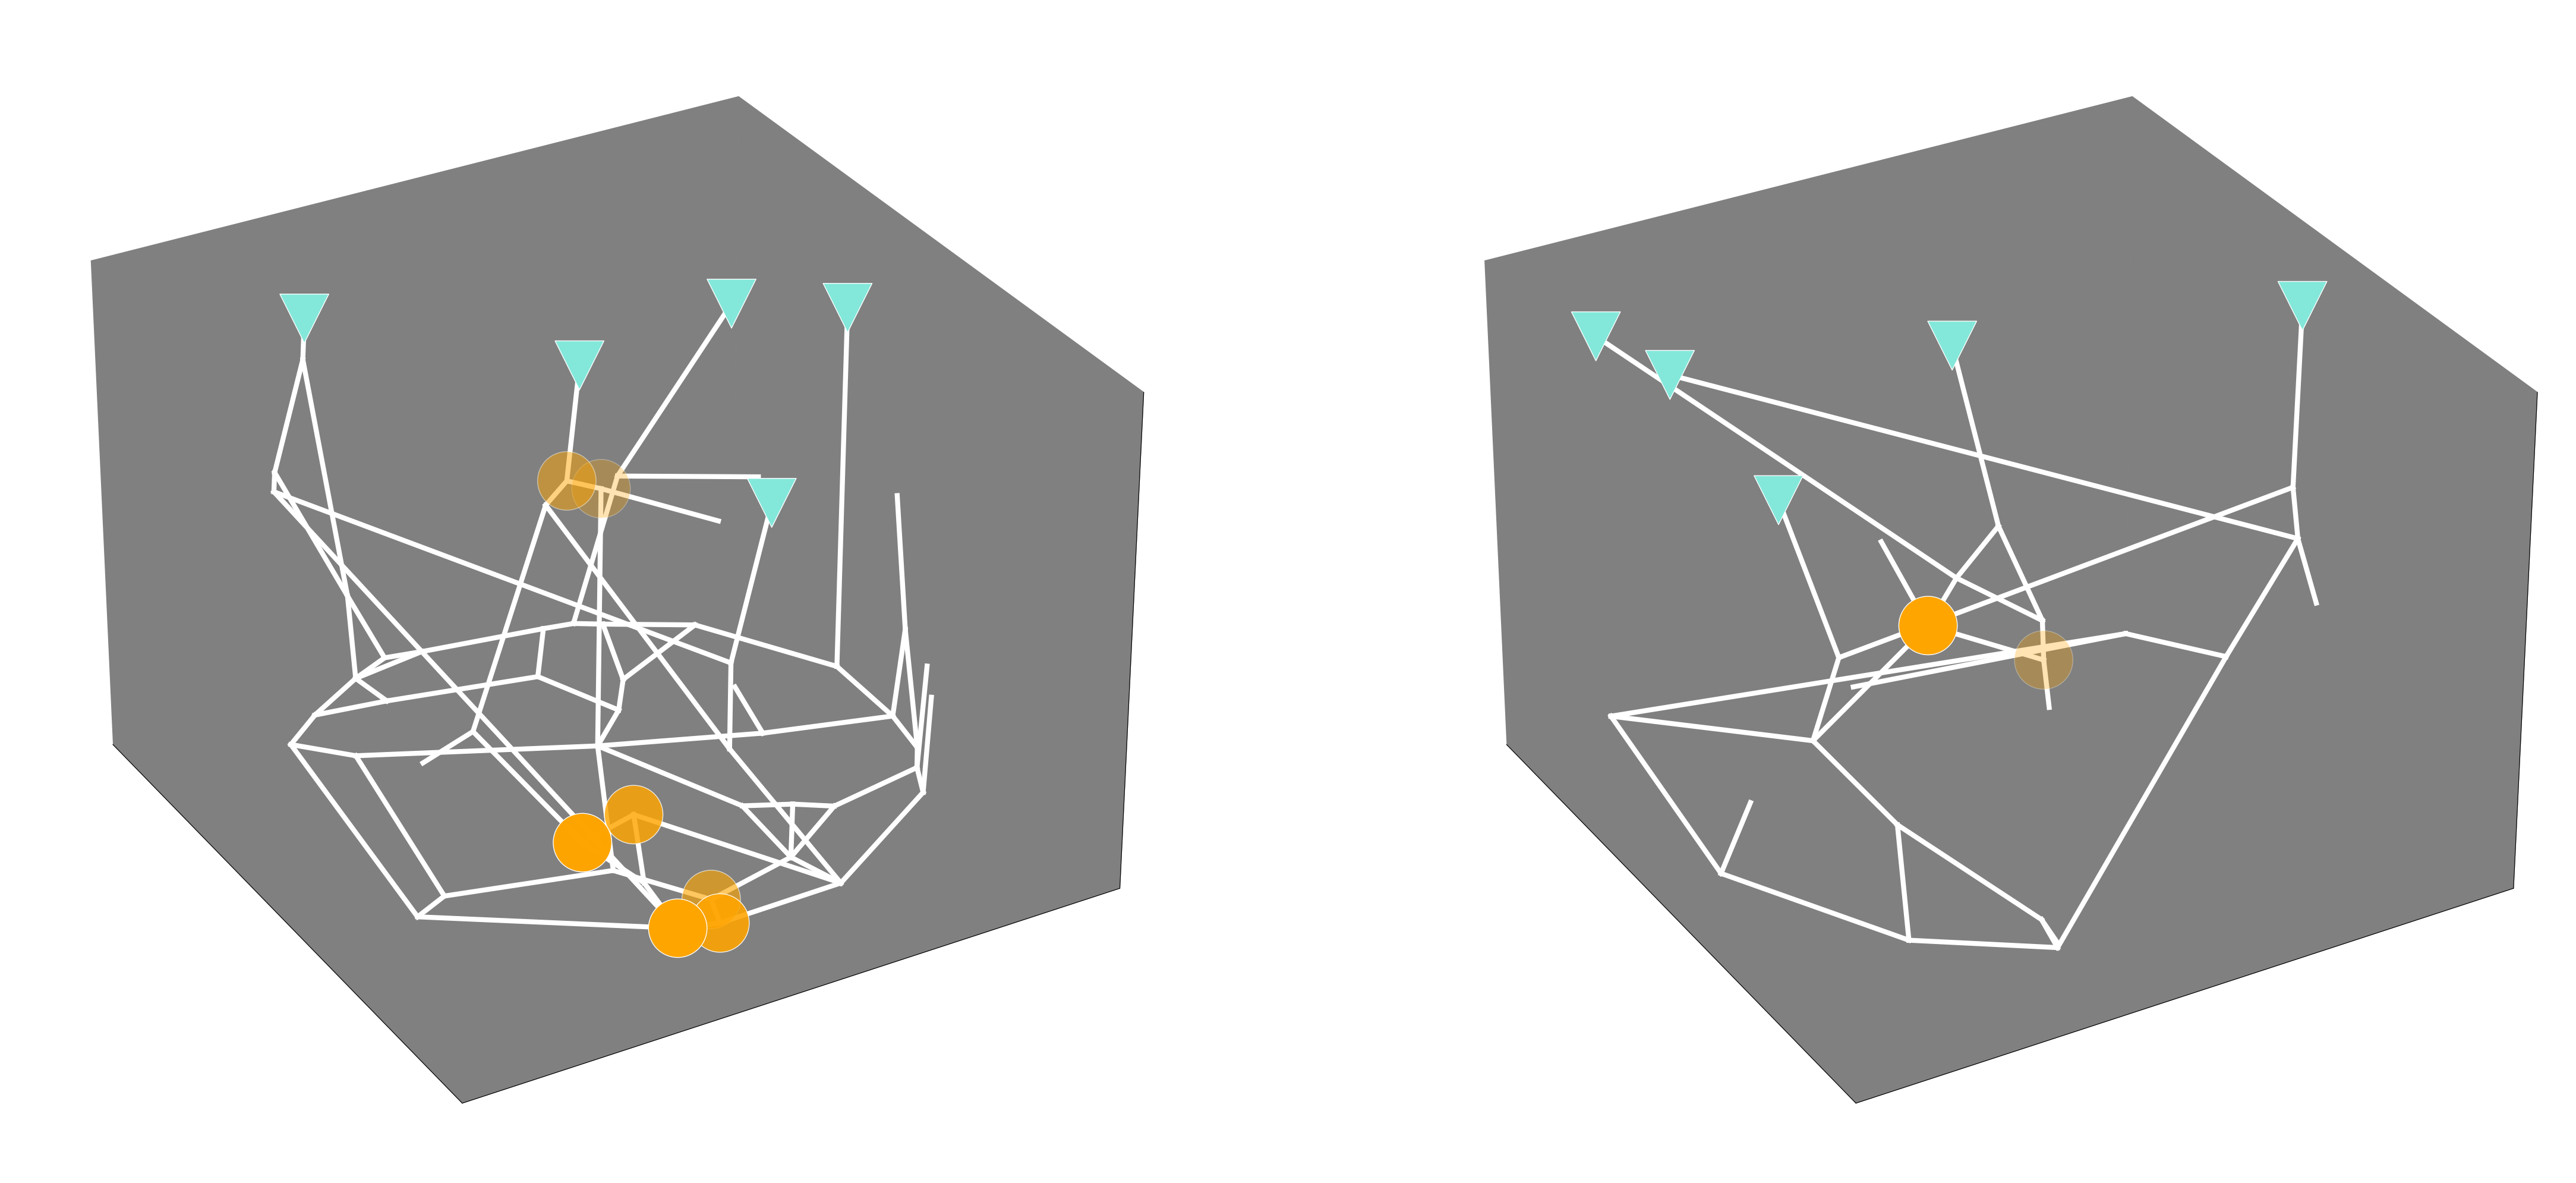

In [36]:
def set_pane_color(ax, color):
    """Set the pane color of a 3D plot."""
    ax.w_xaxis.set_pane_color(color)
    ax.w_yaxis.set_pane_color(color)
    ax.w_zaxis.set_pane_color(color)
start_index=44
x=30
y=330
chsize=5020
nesize=3520
fig = plt.figure(figsize=(60,20))
fig.set_facecolor('white')
text_lab=False
nplot=4
WM=True

if WM==False:
    for i in range(nplot):  # Create 5 plots    
        ax = fig.add_subplot(1, nplot, i+1, projection="3d")  # 1 row, 5 columns, index i+1
        ax.set_facecolor('black')

        G = G_list[start_index + i]  # Get the graph
        plot_graph(G, fig, ax, x, y,chsize,nesize, text_lab)# Plot the graph
    plt.show()
else:
    ax = fig.add_subplot(1, 2, 1, projection="3d")  # 1 row, 5 columns, index i+1
    ax2 = fig.add_subplot(1, 2, 2, projection="3d")  # 1 row, 5 columns, index i+1

    ax.set_facecolor('white')
    ax2.set_facecolor('white')

    set_pane_color(ax, (0.5, 0.5, 0.5, 1))  # Set pane color to grey for ax
    set_pane_color(ax2, (0.5, 0.5, 0.5, 1))
    
    G = G_list[start_index]  # Get the graph
    plot_graph(G, fig, ax, x, y,chsize,nesize, text_lab)# Plot the graph
    G = G_list[start_index+2]  # Get the graph
    plot_graph(G, fig, ax2, x, y,chsize,nesize, text_lab)# Plot the graph
plt.show()

In [131]:
# directory="/media/cf19810/One Touch/CT_ANALYSIS"

directory="/media/ll16598/One Touch/CT_ANALYSIS"
folders = [f for f in os.listdir(directory) if os.path.isdir(os.path.join(directory, f)) and "ANALYSIS" in f]

#os.chdir("/media/ll16598/One Touch/CT_ANALYSIS")


def sort_key(folder_name):
    r_number, c_number = folder_name.split("C")[0][1:], folder_name.split("C")[1][0]
    return (int(r_number), int(c_number))

analysis_folders = sorted(folders, key=sort_key)


volume_folders = []
for analysis_folder in analysis_folders:
    volume_folder = os.path.join(directory, analysis_folder)
    vol_folder = [os.path.join(volume_folder, f) for f in os.listdir(volume_folder) if os.path.isdir(os.path.join(volume_folder, f)) and "VOLUMES" in f]
    volume_folders.extend(vol_folder)


FileNotFoundError: [Errno 2] No such file or directory: '/media/ll16598/One Touch/CT_ANALYSIS'

In [ ]:
volume_folders

In [ ]:
for fol in range(0,len(volume_folders)):
    path_vol=volume_folders[fol]
    print('READING TIFF FILES')
    vol_tiffs = [ f.path for f in os.scandir(path_vol)]
    all_tiffs=[]
    day_list=[]
    d=0
    while d<5:
        for folder in vol_tiffs:
            day=os.path.basename(folder)
            day=day.replace('.tiff', '')
            tiff_list=[]
            stack_list=[]
            if d==0 and 'TUE' in day:
                d+=1
                vol_files = [ f.path for f in os.scandir(folder)]
                day_list.append(day)
                print(day)
                all_tiffs.append(vol_files)
                continue
            if d==1 and 'WED' in day:
                d+=1
                vol_files = [ f.path for f in os.scandir(folder)]
                day_list.append(day)
                print(day)
                all_tiffs.append(vol_files)
                continue
            if d==2 and 'THU' in day:
                d+=1
                vol_files = [ f.path for f in os.scandir(folder)]
                day_list.append(day)
                print(day)
                all_tiffs.append(vol_files)
                continue
            if d==3 and 'FRI' in day:
                d+=1
                vol_files = [ f.path for f in os.scandir(folder)]
                day_list.append(day)
                print(day)
                all_tiffs.append(vol_files)
                continue
            if d==4 and 'MON' in day:
                d+=1
                vol_files = [ f.path for f in os.scandir(folder)]
                day_list.append(day)
                print(day)
#                 for img in vol_files:
#                         name=os.path.basename(img)
#                         image=Image.open(img)
#                         img_name=img.replace('.tiff', '')
#                         #img_data=plt.imread(image)
#                         img_data=np.array(image) #may be as tiff
#                         stack_list.append(img_data)
#                 img_stack=np.array(stack_list)
#                 img_stack[img_stack==0.00000000]=np.nan
#                 all_tiffs.append(img_stack)
                all_tiffs.append(vol_files)
                break

In [ ]:
scale_factor, increment, decrement,allowance = 1.5, 1.2, 9

In [ ]:
ALL_CHAM_VOLS=[]
list_cham_vols=[]
for g in range(0, len(G_list)):
    G=G_list[g]
    attributes = nx.get_node_attributes(G, 'TYPE')
    chamber_nodes = [node for node, type_value in attributes.items() if type_value == 'CHAM']
    ch_list=[]
    for node in chamber_nodes:
        xyz=ast.lteral_eval(G.nodes[node]['coord'])
        ch_list.append(xyz)
        
    tiffs=all_tiffs[g]
    for img in tiffs:
        name=os.path.basename(img)
        image=Image.open(img)
        img_name=img.replace('.tiff', '')
        #img_data=plt.imread(image)
        img_data=np.array(image) #may be as tiff
        stack_list.append(img_data)
    img_stack=np.array(stack_list)
    img_stack[img_stack==0.00000000]=np.nan
    
    ellipsoid_vols=D3.chamber_vols(ch_list,img_stack, scale_factor, increment, decrement,allowance,voxel=voxel)
    ALL_CHAM_VOLS.append(ellipsoid_vols)
    list_cham_vols.extend(ellipsoid_vols)



analysis_df['cham_vol_list']= ALL_CHAM_VOLS